# **Predicting the Quality of White Portuguese Vinho Verde wine**

Resources:  
[1](https://www.kaggle.com/code/halimedogan/red-wine-quality-prediction)

# **PACE stages**
Throughout this project, you'll see references to the problem-solving framework, PACE. This notebook components are labeled with the respective PACE stages: Plan, Analyze, Construct, and Execute. 

# **Pace: Plan Stage**

## Business Understanding
**Add why certification is important**

At the certification phase, quality is evaluated using sensory analysis by a panel of wine experts. The aim of this project is to develop a machine learning model to predict the quality of wine, aimed at reducing the inherent subjectivity present in human sensory analysis. 

**Add na if mapipredict, meaning, makikita din yung factors that lead to better quality of wine. rank the importance of features within the dataset. This insight is invaluable for understanding the driving factors behind predictions. It can guide feature selection in model refinement and data analysis processes** 

**You can use this during conclusion and rec**
By leveraging objective data from analytical tests, the model is intended to support wine tasters, improving the speed and consistency of quality evaluations. For example, the expert may only repeat the tasting if their score is significantly different from the one predicted by the model. 

### Goal and Deliverables

**Goal:** Analyze the provided dataset and build predictive models that can offer insights to CVRVV (The Viticulture Commission of the Vinho Verde Region), a certification agency, to gain a deeper understanding of factors that affect wine quality and to aid wine experts during sensory analysis. 

**Deliverables:**
1. One-page executive summary that would be presented to external stakeholders.
2. Complete code python notebook

### Scope and Limitation
Due to the constraint of data imbalance, the classes of wine that will be predicted in this modeling effort are the following: 
1. **Poor** (quality score of 3-4)
2. **Medium** (quality score of 5-6)
3. **High** (quality score of 7-9)

## Data Understanding
The dataset was taken from [University of California Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality). Each entry in the dataset is the result of a given test (analytical or sensory). The type of wine represented in this dataset is the white variant of the  Portuguese "Vinho Verde" wine.

It contains 4,898 rows&mdash;each representing all test results of a unique white wine sample. It has 12 columns which are listed below: 

  Variable  |Description |
-----|-----|
fixed_acidity|Most acids involved with wine are fixed or nonvolatile (*do not evaporate easily*) [3.8&ndash;15.9]|
volatile_acidity|The amount of acetic acid in wine, which at too high of levels can lead to an unpleasant vinegar taste [0.1&ndash;1.6]|
citric_acid|Found in small quantities, citric acid can add 'freshness' and flavor to wines [0.0&ndash;1.7]|
residual sugar|The amount of sugar remaining after fermentation stops [0.6&ndash;65.8]|
chlorides|The amount of salt in the wine [0.01&ndash;0.61]|
free_sulfur_dioxide|The free form of SO2 exists in equilibrium between molecular SO2 (*as a dissolved gas*) and bisulfite ion [1&ndash;289]|
total_sulfur_dioxide|Amount of free and bound forms of sulfur dioxide gas (SO2) [6&ndash;440]|
density|[0.987&ndash;1.039]|
pH|Describes how acidic or basic a wine is [2.7&ndash;4.0]|
sulphates|A wine additive which can contribute to sulfur dioxide gas (SO2) levels, which acts as an antimicrobial and antioxidant [0.2&ndash;2.0]|
alcohol|[8.0&ndash;14.9]|
quality|Based on sensory data [0&ndash;10]|


**Note:** The wine samples came from different manufacturers from the northwest region of Portugal and were tested at the official certification entity called CVRVV. Therefore, expect different range of results for each given test. 

## Step 1. Imports

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Import the modeling algorithm to be used
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# To address the class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline


# To save the fitted models
import pickle

# For nested cross-validation
from sklearn.model_selection import StratifiedKFold, cross_validate

In [2]:
# load dataset
df0 = pd.read_csv('winequality-white.csv', sep=';')
df0.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Step 2. Data Exploration
* Understand variables
* Clean the dataset (remove duplicates)

### Gather basic information about the data

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### Rename columns

In [4]:
# Rename columns
df0.rename(columns={'fixed acidity': 'fixed_acidity',
                    'volatile acidity': 'volatile_acidity',
                    'citric acid': 'citric_acid',
                    'residual sugar': 'residual_sugar',
                    'free sulfur dioxide': 'free_sulfur_dioxide',
                    'total sulfur dioxide': 'total_sulfur_dioxide'}, inplace=True)

# Diplay the column names after the updata
df0.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### Gather descriptive statistics about the data

In [5]:
df0.describe(include='all')

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Check missing values

In [6]:
df0.isna().any(axis=0).sum()

0

* There are no missing values in the dataset. 

### Check duplicates

In [7]:
# Check for duplicates
df0.duplicated().sum()

937

In [8]:
# Inspect the duplicated rows of all columns
df0[df0.duplicated(keep=False)]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.800000,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.500000,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.100000,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4851,6.4,0.33,0.44,8.9,0.055,52.0,164.0,0.99488,3.10,0.48,9.600000,5
4855,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000,6
4856,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000,6
4879,6.6,0.34,0.40,8.1,0.046,68.0,170.0,0.99494,3.15,0.50,9.533333,6


* There are 937 rows of duplicated data. As shown in the table above (*look at the last 2 rows*), the dataset is composed of several continuous variables, the likelihood of two or more wine samples having the sample exact information in all the columns in the dataset is extremely low. So it is reasonable to drop duplicates.
* Since the assumption is that each row should represent a unique wine sample, the duplicates should be dropped to ensure reliable analysis. 

In [9]:
# Drop duplicates and save the resulting dataframe in a new variable as needed
df = df0.drop_duplicates(keep='first')

# Display the shape of the dataset
df.shape

(3961, 12)

# **pAce: Analyze Stage**
* Perform Exploratory Data Analysis (EDA) to analyze relationships between variables

### **`quality`:** Check the target variable's class distribution

* Assessed by a minimum of three sensory blind tastings, wine experts graded the wine on a scale ranging from 0 (*very poor*) to 10 (*very excellent*).

**What does the term `quality` mean?** 
* According to Hopfer et al. (2014) [^1], wine quality has a strong correlation to aroma and flavor descriptions. When discussing the quality of wine, both consumers and wine experts use hedonic descriptors, which refer to pleasant and unpleasant sensations felt when drinking wine.[^1]. `quality` in this context refers to aroma, flavor, and hedonic descriptors. 

[^1]: Hopfer, H., & Heymann, H. (2014). Judging wine quality: Do we need experts, 
consumers or trained panelists? Food Quality and Preference, 32, 221-233. 
10.1016/j.foodqual.2013.10.004

In [10]:
df['quality'].value_counts(normalize=True).sort_values(ascending=False)

quality
6    0.451401
5    0.296642
7    0.173946
4    0.038627
8    0.033072
3    0.005049
9    0.001262
Name: proportion, dtype: float64

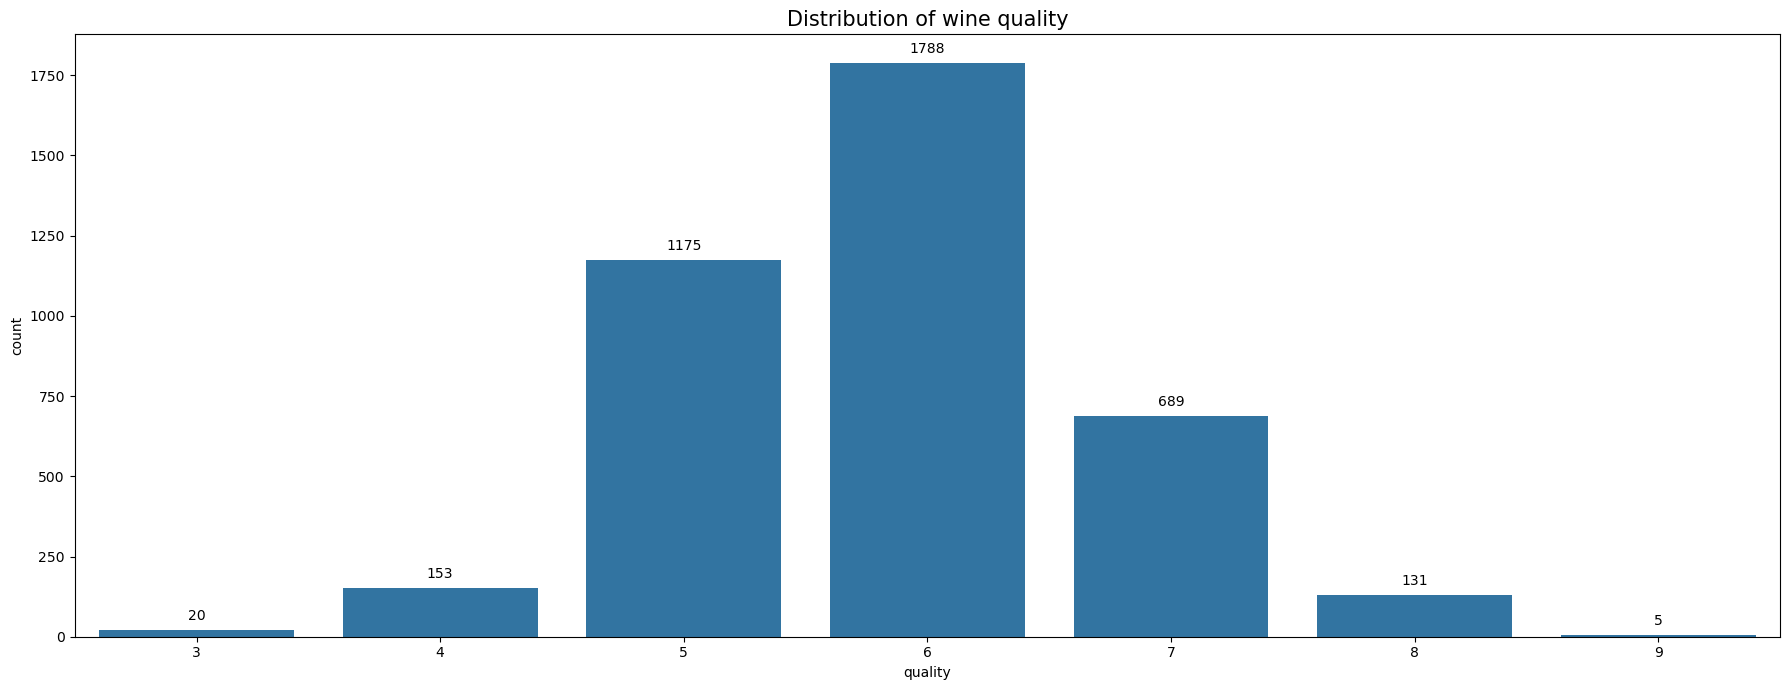

In [11]:
plt.figure(figsize=(18,7))
ax = sns.countplot(x=df['quality'])
ax.set_title('Distribution of wine quality', fontsize='15')

def add_value_labels(ax, spacing=5):
    """
    Add labels to the end of each bar.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label
        space = spacing
        
        # Vertical alignment 
        va = 'bottom'

        # Use Y value as label and format number with one decimal place
        label = '{:1.0f}'.format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords='offset points', # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.tight_layout()
plt.show()

#### Making new multi-class classification for the target variable
* Divide the wine dataset into poor, average, good
    1. `poor` = quality of `0-4`, in the actual wine dataset, it will only include quality of `3-4`
    2. `medium` = quality of `5-6` 
    3. `high` = quality of `7-10`, in the actual wine dataset, it will only include quality of `7-9`

In [12]:
df = df.copy()              # To eliminate the SettingWithCopyWarning
bins = [0, 5, 7, 11]                
class_names = ['poor', 'medium', 'high']
df['quality_cat']= pd.cut(df['quality'], bins = bins, labels=class_names,     
                            include_lowest=True, right=False)      

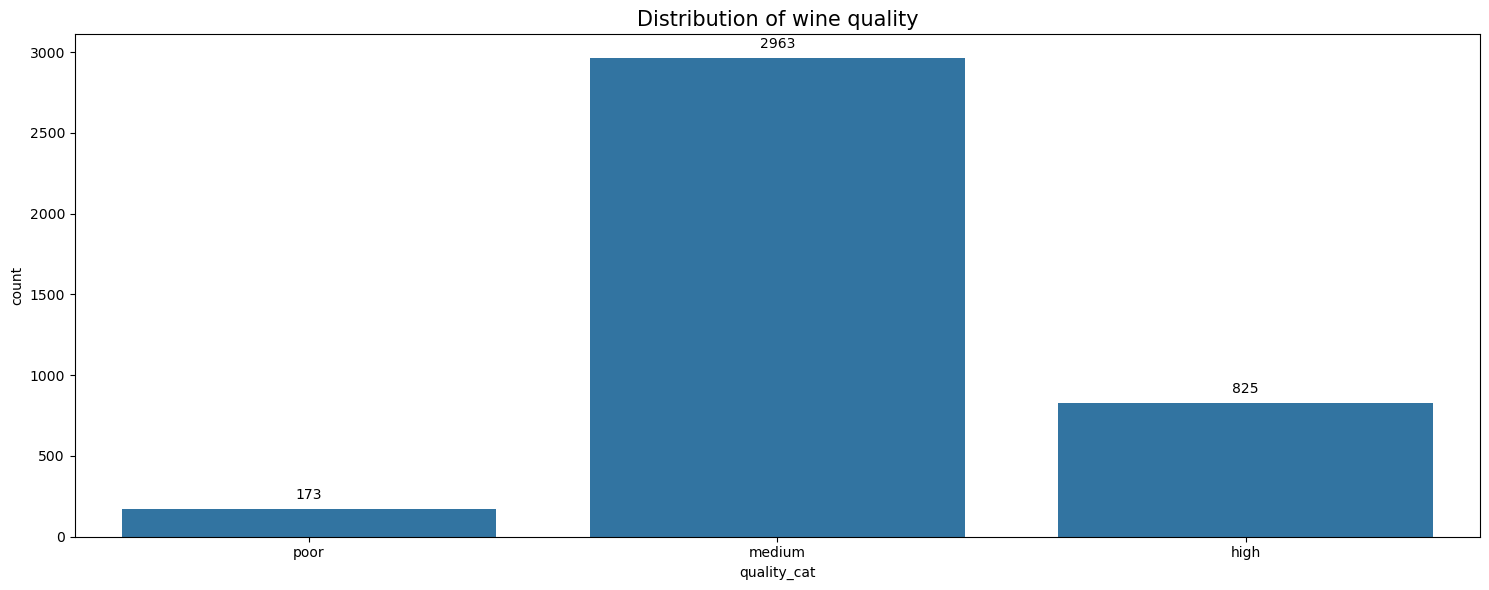

In [13]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x=df['quality_cat'])
ax.set_title('Distribution of wine quality', fontsize='15')

add_value_labels(ax)
plt.tight_layout()
plt.show()

* The classes in the `quality` column are ordered and imbalanced. There are more normal wines than poor and/or good wines. For instance, the wine with a quality of 6 comprises most of the dataset, about 45.14% (1788 out of 3,961 wine samples).

* There are few good wines (*with quality of 7 to 9*) and even fewer poor quality wines (*with quality of 3 and 4*)

### Check the distribution of independent variables

In [14]:
# Helper function for boxplots and histograms
def distribution_plotter(column_str, median_text=True, **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.boxplot(x=df[column_str], ax=axes[0])
    axes[0].set_title(f'{column_str} boxplot')

    median = round(df[column_str].median(),2)
    sns.histplot(x=df[column_str], **kwargs, ax=axes[1])
    plt.axvline(x=median, color='red', linestyle='--')
    if median_text == True: 
        axes[1].text(0.25, 0.85, f'median={median}', color='red',
                    ha='left', va='top', transform=axes[1].transAxes)
    else: 
        print(f'Median: {median}')
    axes[1].set_title(f'{column_str} histogram')

    plt.tight_layout()
    plt.show()

In [15]:
def empirical_verifier(column_str):
    '''
    Verify if the data follows a normal distribution. 
    Input: column in string format
    Output: Percentage distribution of data
    
        Empirical rule 1: 1STD has 68% of the data
        Empirical rule 2: 2STD has 95% of the data
        Empirical rule 3: 3STD has 99.7% of the data
    '''
    mean = df[column_str].mean()
    std = df[column_str].std()
    i = 1
    while i < 4: 
        lower_limit = mean - (i*std)
        upper_limit = mean + (i*std)
        percent_sd = ((df[column_str]>=lower_limit) & (df[column_str] <= upper_limit)).mean()
        print(f'{i}SD: {percent_sd:1.2%}')
        i += 1

#### **`fixed_acidity`:** $g(tartaric$ $acid)$ / $dm^3$ 
Most acids involved with wine are fixed or nonvolatile (*do not evaporate easily*)

In [16]:
df['fixed_acidity'].describe()

count    3961.000000
mean        6.839346
std         0.866860
min         3.800000
25%         6.300000
50%         6.800000
75%         7.300000
max        14.200000
Name: fixed_acidity, dtype: float64

Median: 6.8


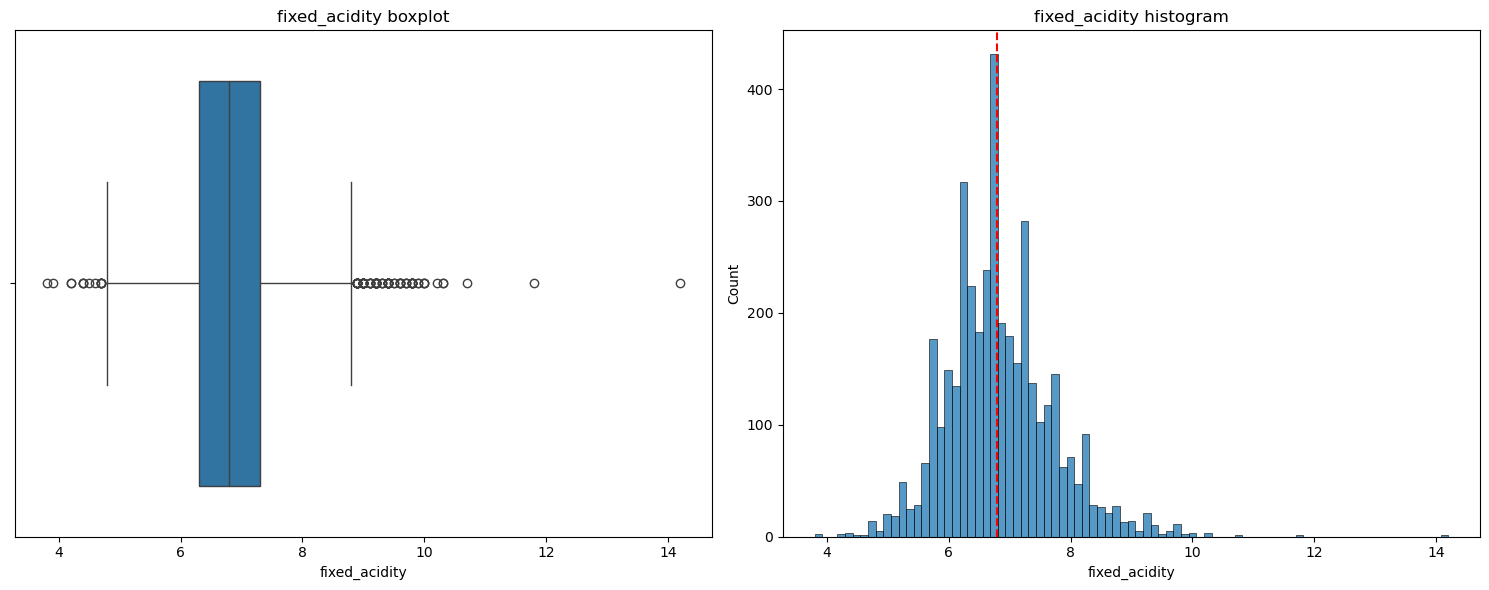

In [17]:
distribution_plotter('fixed_acidity', median_text=False)

In [18]:
empirical_verifier('fixed_acidity')

1SD: 73.57%
2SD: 94.80%
3SD: 99.17%


* From the histogram, there are more than one peak in the distribution.

* From the boxplot, there is a presence of outliers. If models that are sensitive to outliers are to be used (i.e. logistic regression), consider imputing the outliers. 

#### **`volatile_acidity`:** $g(acetic$ $acid)$ / $dm^3$  
Responsible for the level of sourness in the wines, which at too high of levels can lead to an unpleasant vinegar taste. 

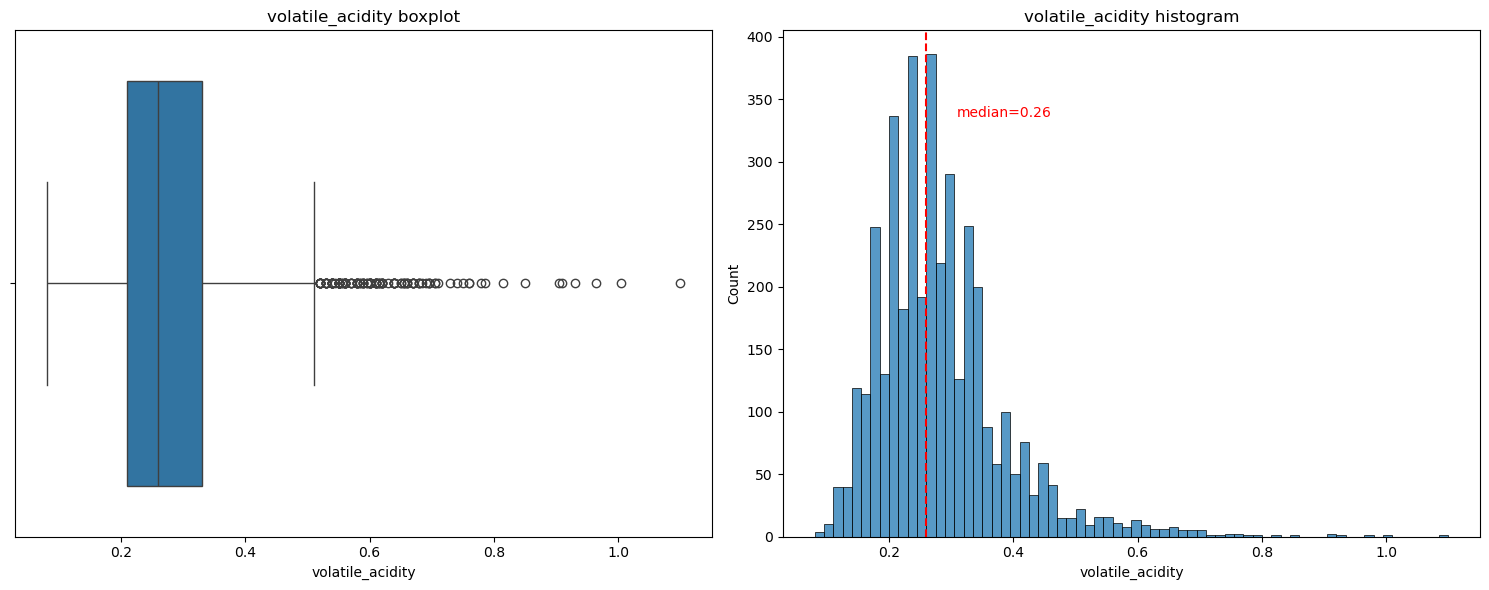

In [19]:
distribution_plotter('volatile_acidity', median_text=True)

In [20]:
empirical_verifier('volatile_acidity')

1SD: 76.37%
2SD: 95.76%
3SD: 98.26%


* The distribution is right-skewed; there are more values in the left side than on the right side of the histogram.
   
* From the boxplot, there is a presence of outliers. If models that are sensitive to outliers are to be used (i.e. logistic regression), consider imputing the outliers.

#### **`citric_acid`:** $g / dm^3$  
Found in small quantities, citric acid can add 'freshness' and flavor to wines. 

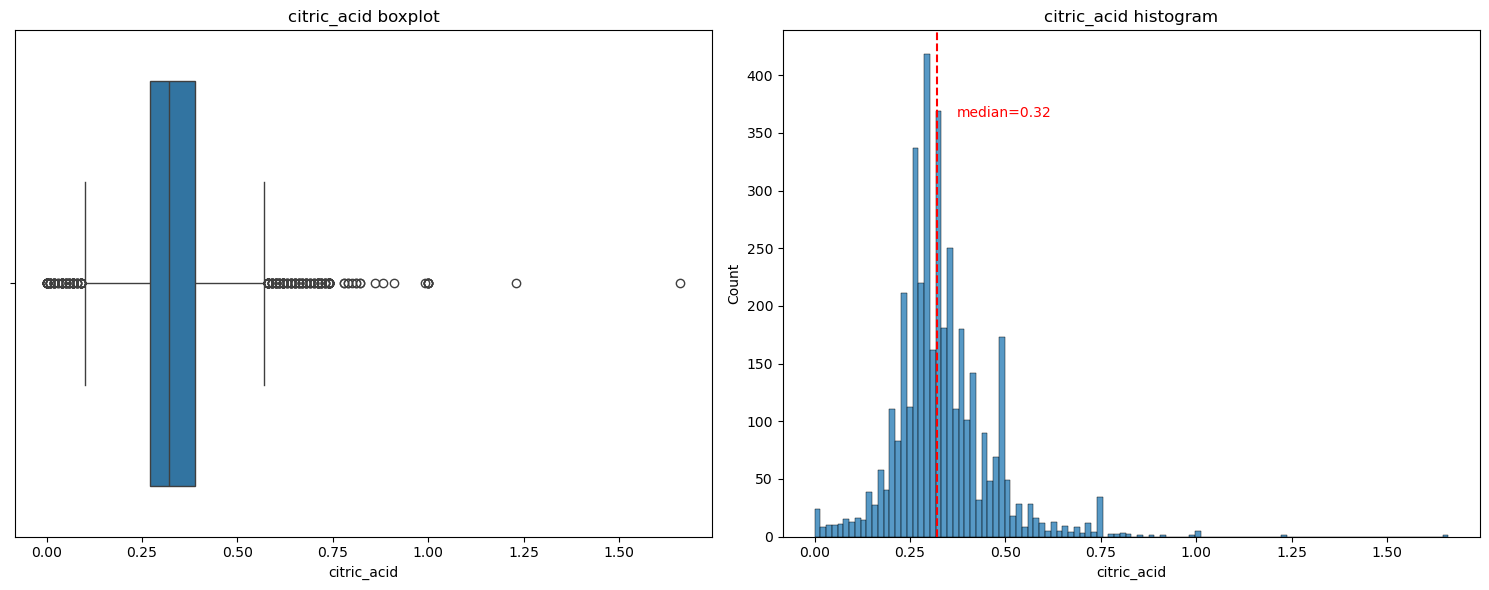

In [21]:
distribution_plotter('citric_acid', median_text=True)

In [22]:
empirical_verifier('citric_acid')

1SD: 75.71%
2SD: 94.65%
3SD: 98.23%


In [23]:
df['citric_acid'].describe()

count    3961.000000
mean        0.334332
std         0.122446
min         0.000000
25%         0.270000
50%         0.320000
75%         0.390000
max         1.660000
Name: citric_acid, dtype: float64

* There are wine samples with 0 $g / dm^3$.
* There are also wine samples that have 1.0 $g / dm^3$ of citric acid, which is well above the median value of 0.32 $g / dm^3$.
* There are outliers below and above the 1.5 times the IQR (interquartile range)

#### **`residual_sugar`:** $g / dm^3$  
The amount of sugar remaining after fermentation stops.    

**Note:**   
* It is rare to find wines with less than $1$ $g / dm^3$
* Wine with greater than  $45$ $g / dm^3$ are considered sweet[^2].

[^2]: Horváth, B. O., Sárdy, D. N., Kellner, N., & Magyar, I. (2020). Effects of High Sugar 
Content on Fermentation Dynamics and Some Metabolites of Wine-Related Yeast 
Species Saccharomyces cerevisiae, S. uvarum and Starmerella bacillaris. Food 
technology and biotechnology, 58(1), 76–83.

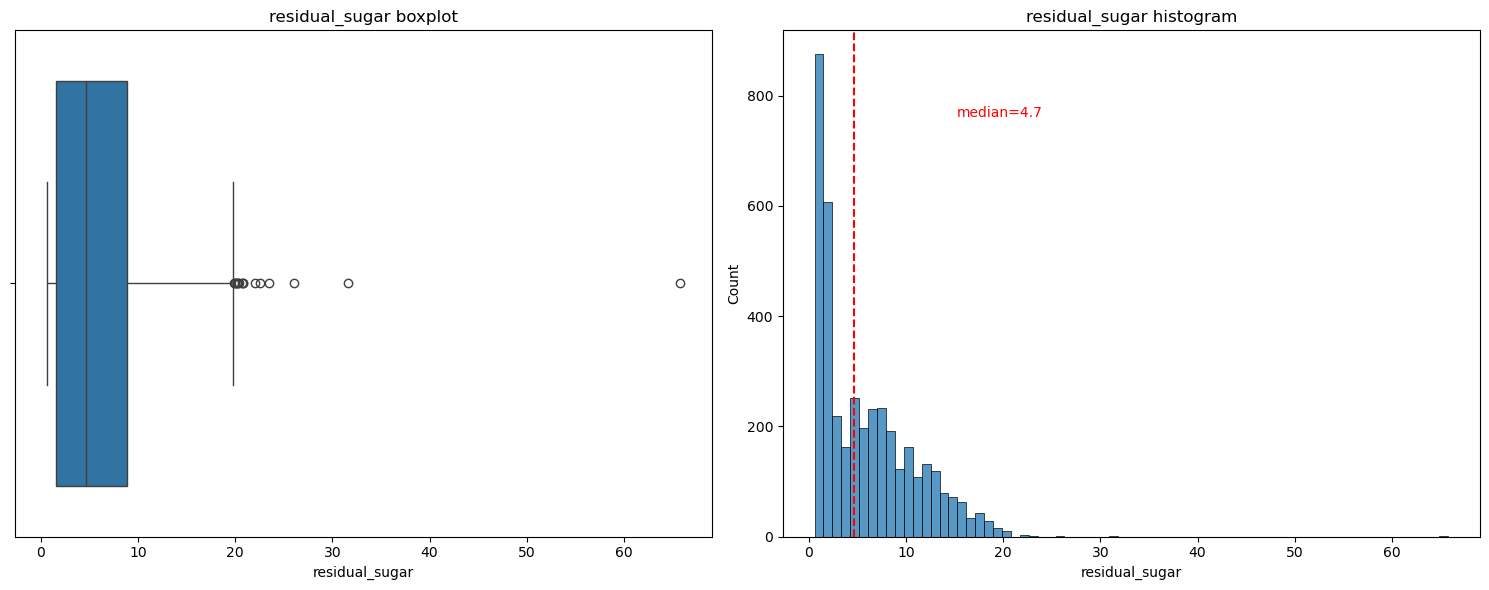

In [24]:
distribution_plotter('residual_sugar', median_text=True)

In [25]:
df['residual_sugar'].describe()

count    3961.000000
mean        5.914819
std         4.861646
min         0.600000
25%         1.600000
50%         4.700000
75%         8.900000
max        65.800000
Name: residual_sugar, dtype: float64

* The distribution is right-skewed; most sample of wine has a residual sugar content of less than 10.

#### **`chlorides`:** $g(sodium$ $chloride)$ / $dm^3$
The amount of salt in the wine. 

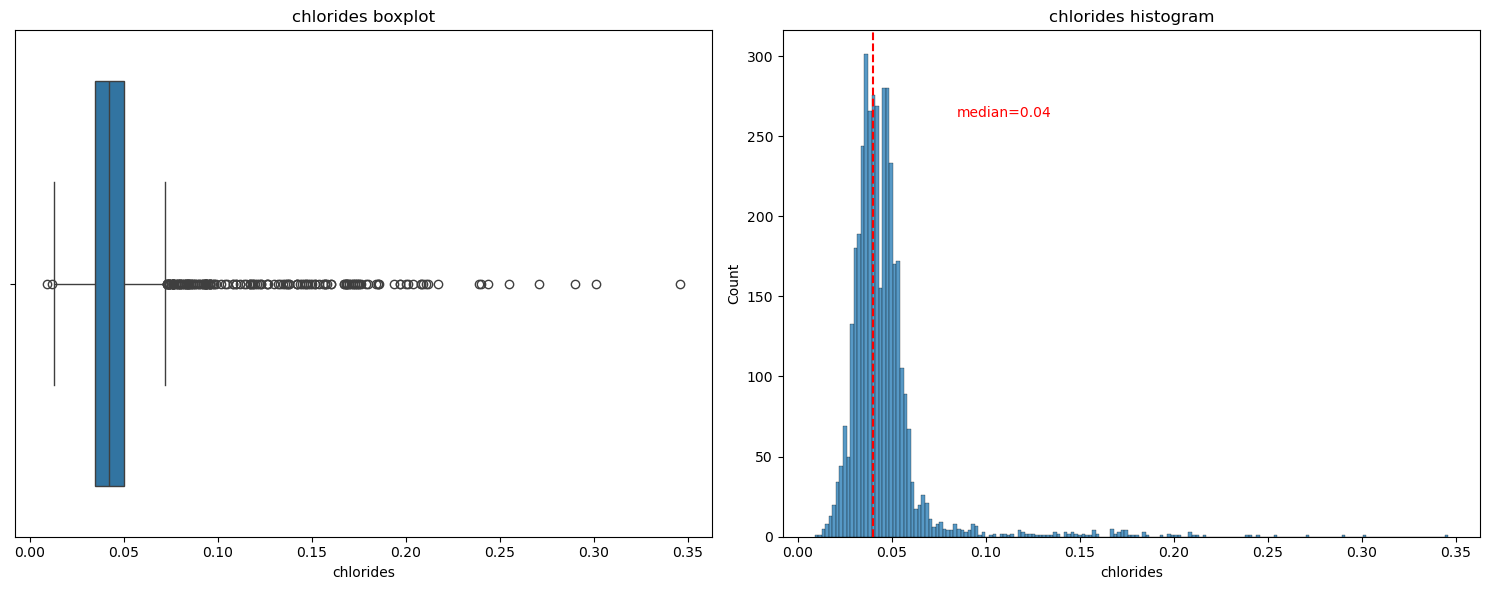

In [26]:
distribution_plotter('chlorides', median_text=True)

In [27]:
df['chlorides'].describe()

count    3961.000000
mean        0.045905
std         0.023103
min         0.009000
25%         0.035000
50%         0.042000
75%         0.050000
max         0.346000
Name: chlorides, dtype: float64

* The distribution is right-skewed; most sample of wine has a `chlorides` content of less than 0.1.

#### **`free_sulfur_dioxide`:** $mg / dm^3$
The free form of sulfur dioxide ($SO_2$) exists in equilibrium between molecular $SO_2$ (a dissolved gas) and bisulfite ion.  
* It prevents microbial growth and the oxidation of wine. 

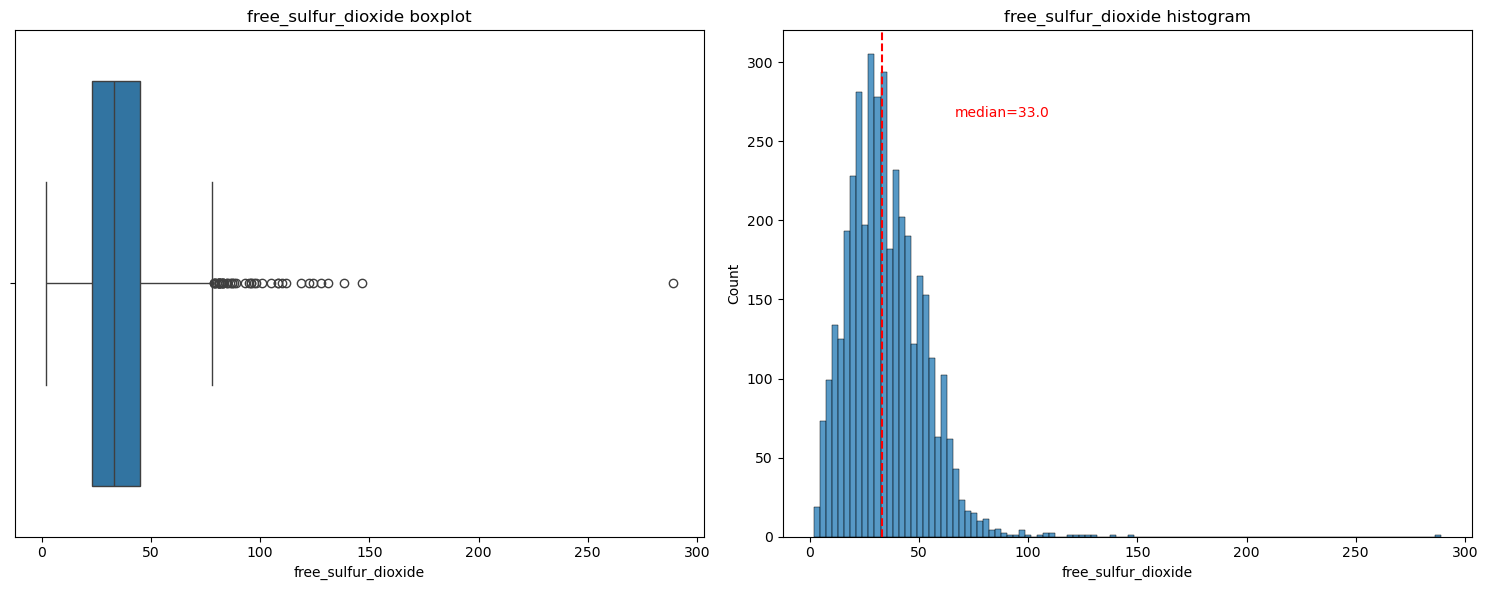

In [28]:
distribution_plotter('free_sulfur_dioxide', median_text=True)

#### **`total_sulfur_dioxide`:** $mg / dm^3$
The amount of free and bound forms of $SO_2$. 
* In low concentrations, $SO_2$ is mostly undetectable in wine.
* But at free $SO_2$ concentrations over 50 ppm (or 50 $mg / dm^3$), $SO_2$ becomes evidents in the note and taste of wine. 

Median: 133.0


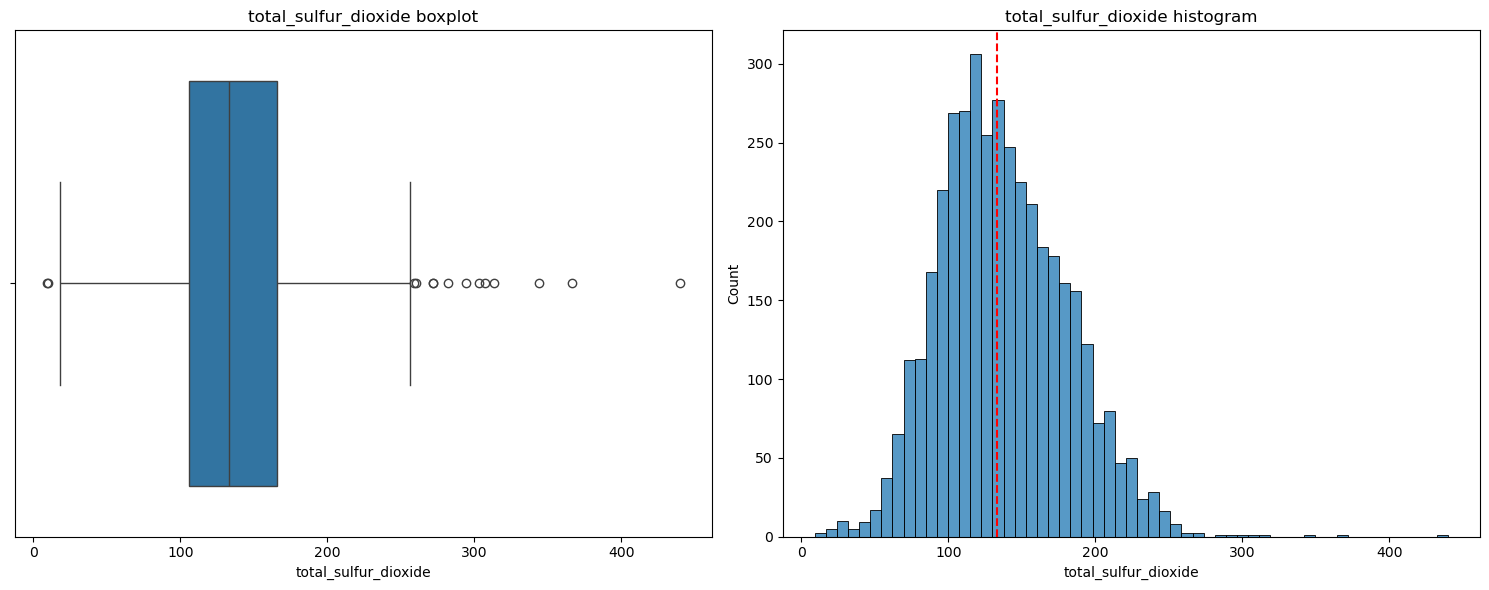

In [29]:
distribution_plotter('total_sulfur_dioxide', median_text=False)

In [30]:
empirical_verifier('total_sulfur_dioxide')

1SD: 68.24%
2SD: 96.01%
3SD: 99.75%


* Based on the histogram and the empirical rule, the `total_sulfur_dioxide` column follows an approximately normal distribution. However, outliers are still present.

#### **`density`:** $g / cm^3$
The density of wine is close to that of that of water. Note: Some wines are meant to be denser than others; and wines such as Vinho Verde are not meant to be dense.

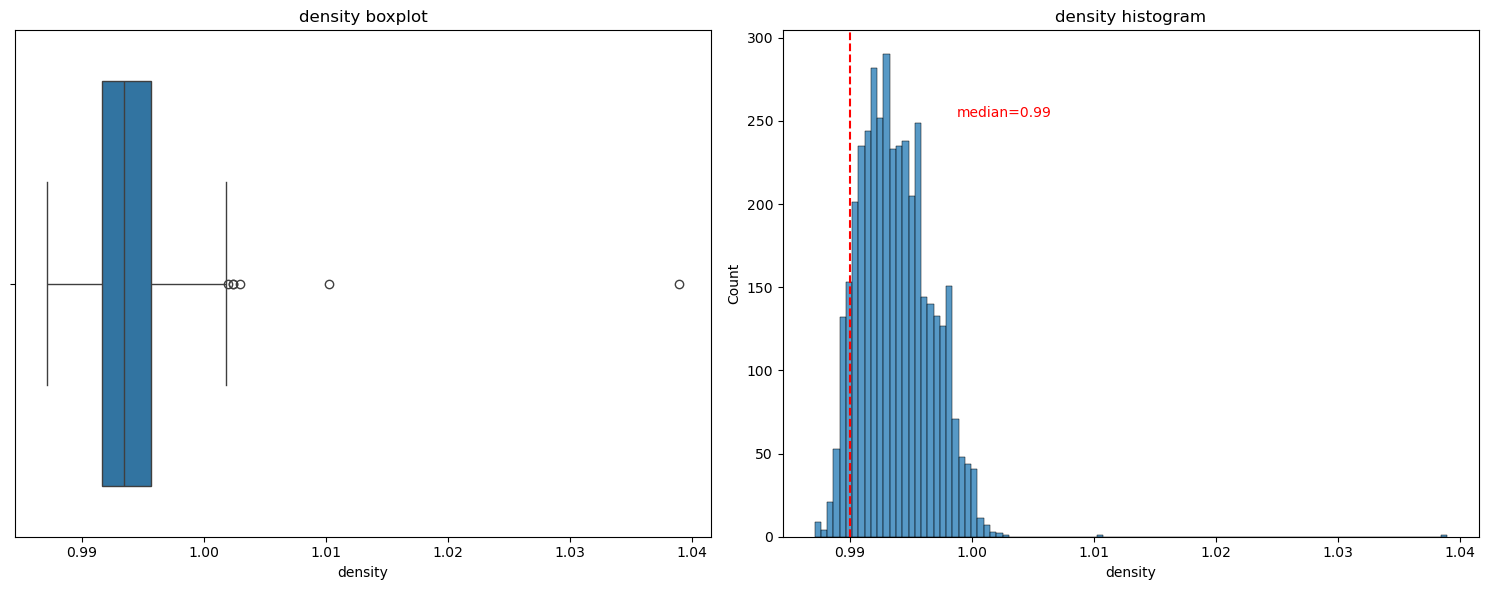

In [31]:
distribution_plotter('density', median_text=True)

In [32]:
empirical_verifier('density')

1SD: 66.47%
2SD: 97.22%
3SD: 99.92%


* Approximately normal distribution

* Present of few outliers with density value of greater than 1

#### **`pH`:**
Describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic). 
* Most wines are between 3-4 on the pH scale. 

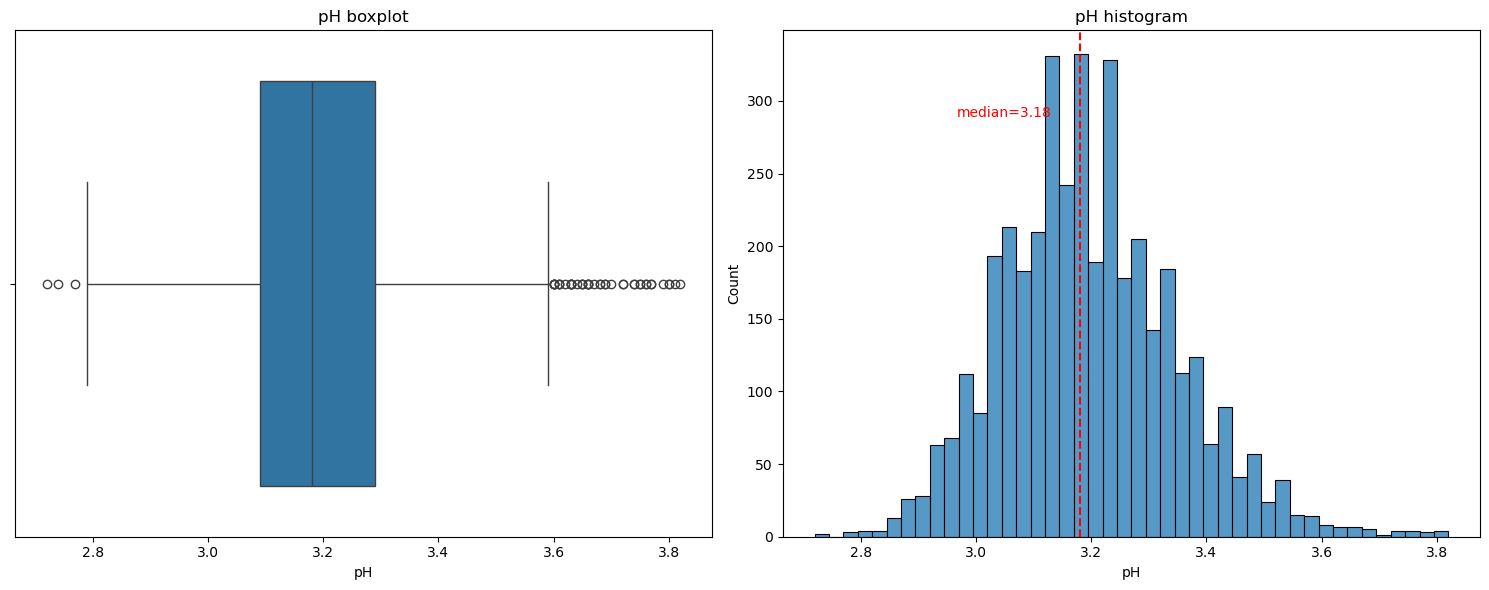

In [33]:
distribution_plotter('pH', median_text=True)

In [34]:
empirical_verifier('pH')

1SD: 69.10%
2SD: 95.28%
3SD: 99.32%


* Closely follows a normal distribution

* There is a presence of outliers below and above the 1.5 times of the Inter Quartile Range

#### **`sulphates`:** $g (potassium$ $sulphate$) / $dm^3$
A wine additive that can contribute to sulfur dioxide gas levels, which acts as an antimicrobial and antioxidant. 

Median: 0.48


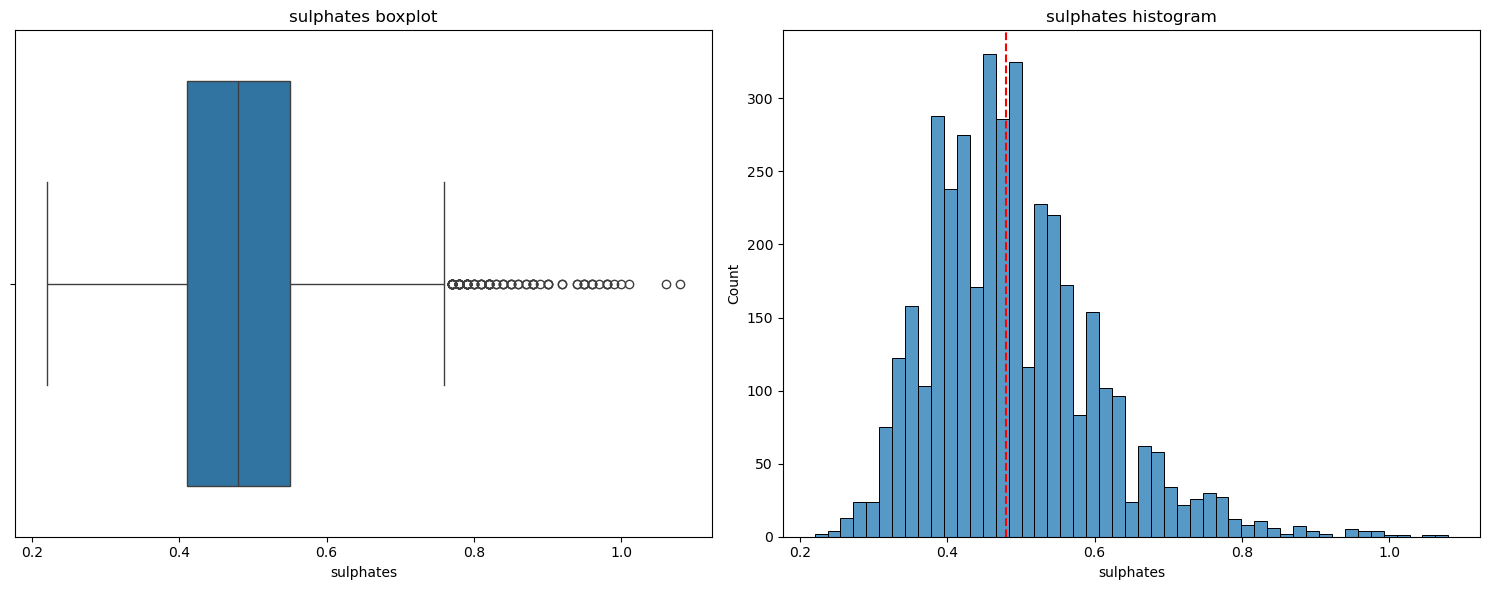

In [35]:
distribution_plotter('sulphates', median_text=False)

In [36]:
empirical_verifier('sulphates')

1SD: 72.86%
2SD: 95.38%
3SD: 99.04%


#### **`alcohol`:** %vol.

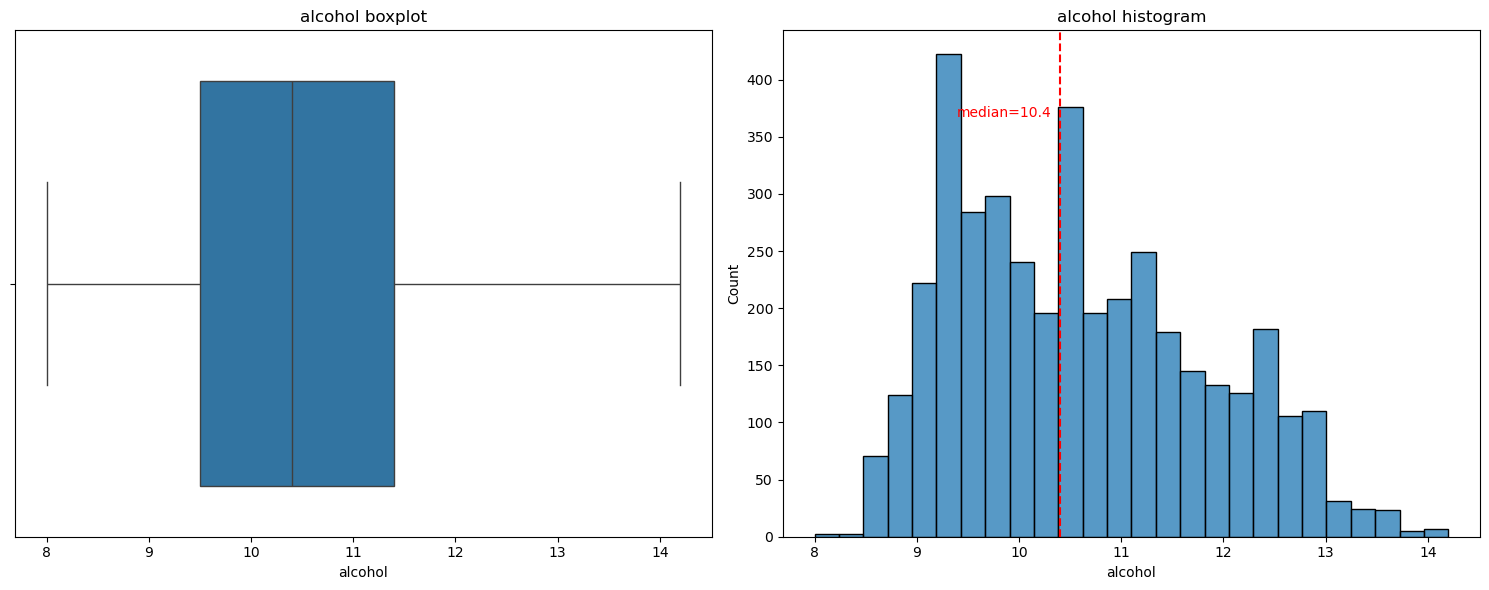

In [37]:
distribution_plotter('alcohol', median_text=True)

In [38]:
empirical_verifier('alcohol')

1SD: 64.13%
2SD: 97.68%
3SD: 100.00%


* The alcohol content of all the wine samples are within below and above the 3 times standard deviation. 

### Check the relationship between variables

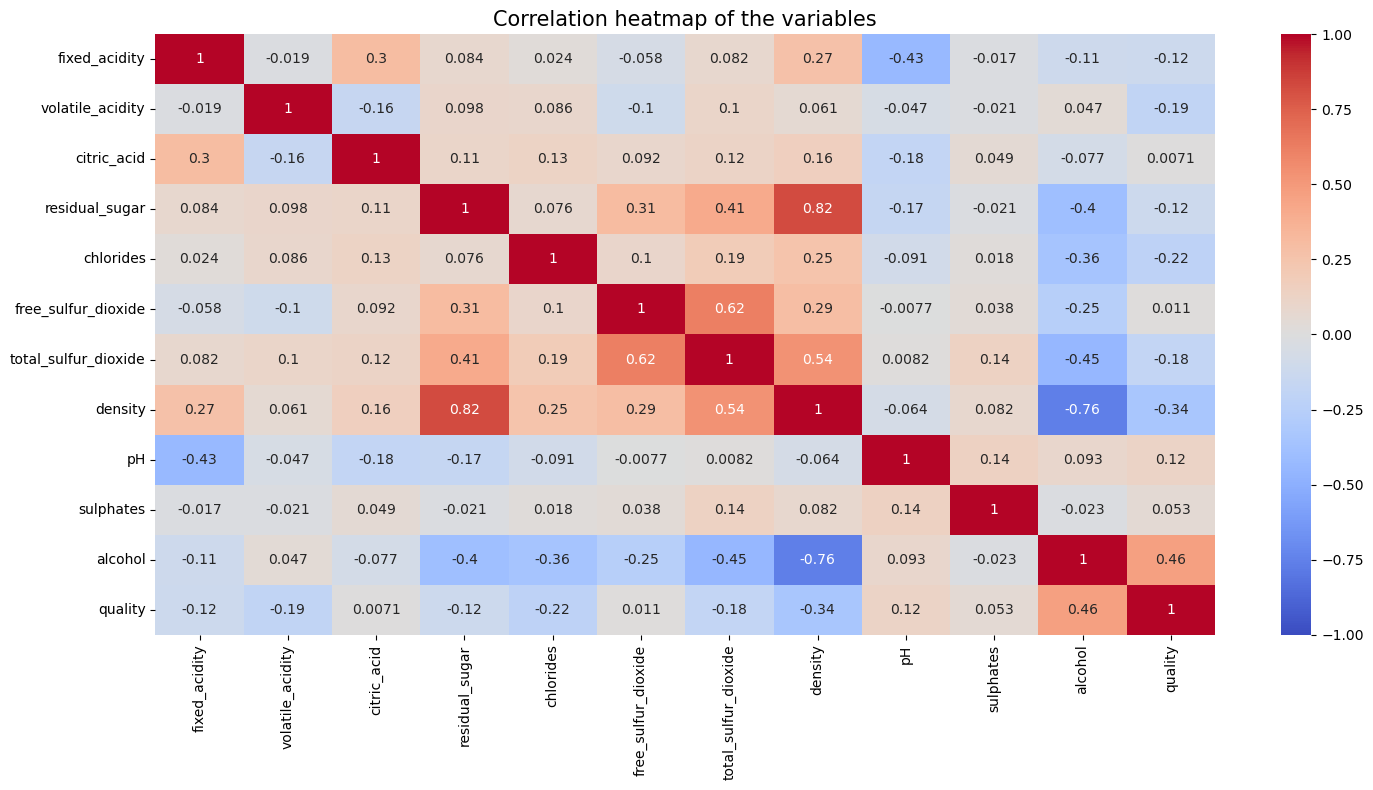

In [39]:
# Correlation heatmap 
plt.figure(figsize=(15,8))
fig = sns.heatmap(df.corr(method='pearson', numeric_only=True), vmin=-1, vmax=1,
                 annot=True, cmap='coolwarm')
fig.set_title('Correlation heatmap of the variables', fontsize='15')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

* Based on the correlation heatmap, `residual_sugar`, `density`, `free_sulfur_dioxide`, `total_sulfur_dioxide` and `alcohol` are significantly correlated to each other.
    1. `residual_sugar` and `density` have high correlation: choose `density`
    2. `total_sulfur_dioxide` and `free_sulfur_dioxide` have high correlation: choose `total_sulfur_dioxide`
 

* Also, `quality` has moderate positive correlation to `alcohol` and moderate negative correlation to `density`, `chlorides`, `volatile_acidity`

In [40]:
# Outputs a boxplot of quality predictors
def quality_predictor(column_str, space):
    '''
    Arguments: 
        * column_str: column name in string format
        * space: space between the bar and the bar label
    '''
    plt.figure(figsize=(15,7))
    median = df[column_str].median()
    print(f'Broken red line (Median value): {median:1.2f}')
    ax = sns.barplot(data=df, x='quality', y=column_str, hue='quality_cat', alpha=0.4)
    plt.axhline(median, color='red', linestyle='--')
    plt.legend(bbox_to_anchor=(1,1))
    for container in ax.containers:
        ax.bar_label(container, padding=space, fmt='%.3f') 
    ax.set_title(f'{column_str} vs quality')
    plt.show();

Broken red line (Median value): 10.40


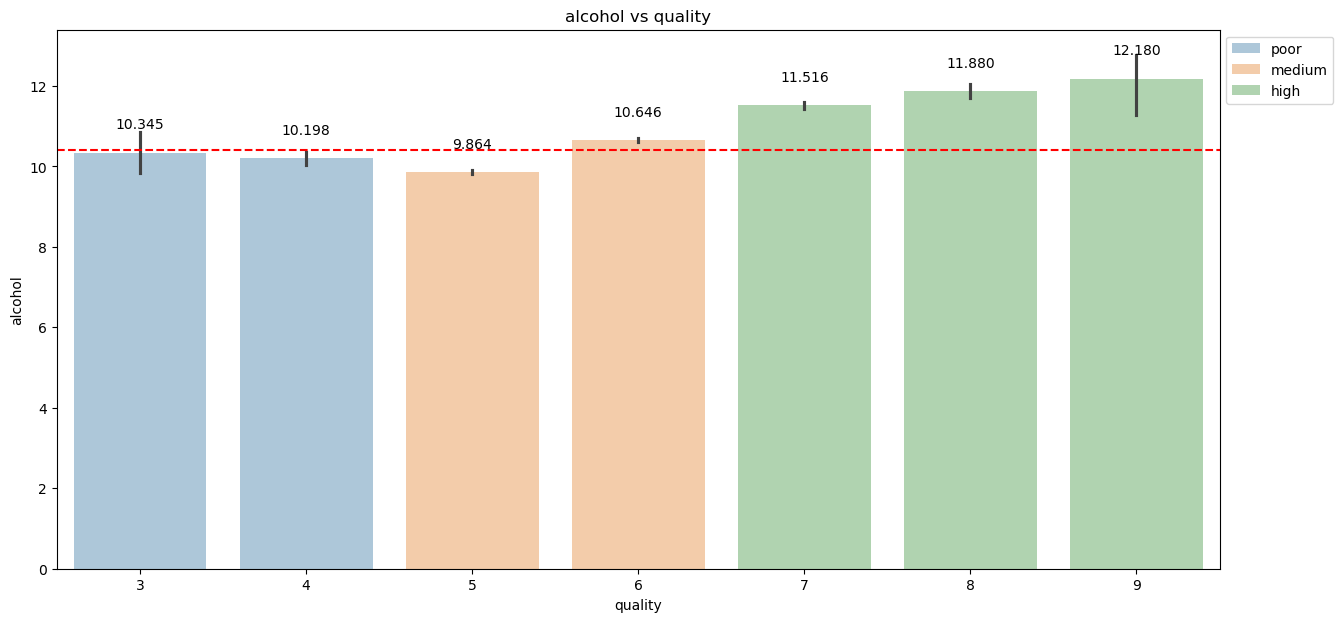

In [41]:
# quality vs alcohol
quality_predictor('alcohol', 15)

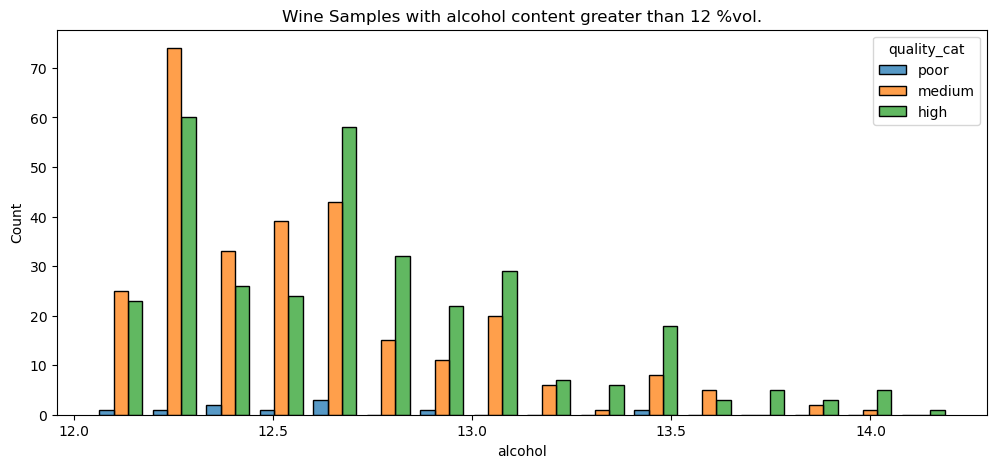

In [42]:
alcohol_greater_than_12 = df[df['alcohol']>12]
plt.figure(figsize=(12,5))
fig = sns.histplot(data=alcohol_greater_than_12, x='alcohol', 
                  hue='quality_cat',
                  multiple='dodge', shrink=.8)
fig.set_title('Wine Samples with alcohol content greater than 12 %vol.')
plt.show()

* High-quality wine seems to have higher alcohol content, in contrast, poor-quality wines have lower alcohol content.
* This confirms that alcohol content is a good predictor of the quality of wine. 

Broken red line (Median value): 0.99


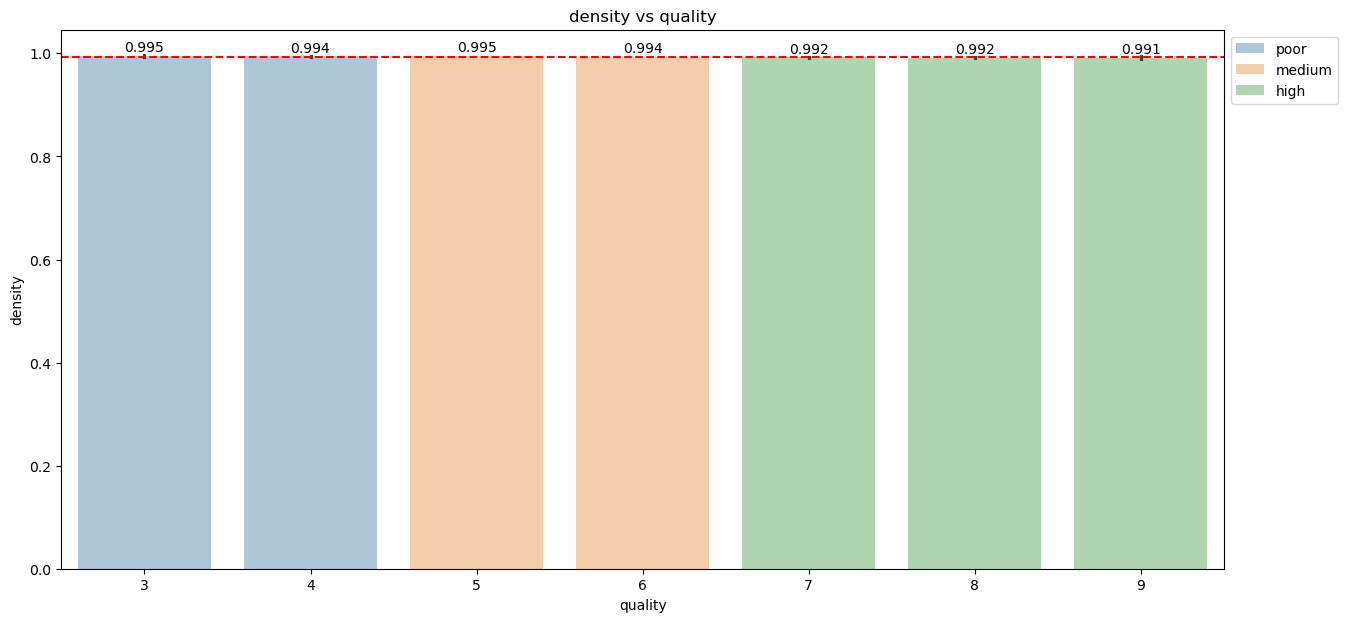

In [43]:
# quality vs density
quality_predictor('density', 1)

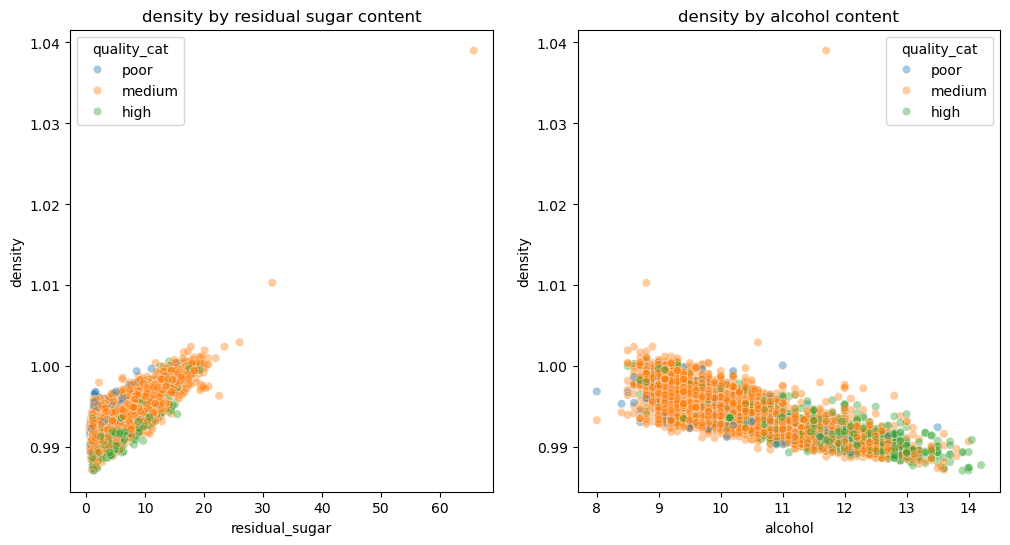

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=df, x='residual_sugar', y='density', 
                hue='quality_cat', alpha=0.4, ax=axes[0])
axes[0].set_title('density by residual sugar content')

sns.scatterplot(data=df, x='alcohol', y='density', 
                hue='quality_cat',alpha=0.4, ax=axes[1])
axes[1].set_title('density by alcohol content')
plt.show()

* Density seems to have some correlation with residual sugar and alcohol content.

* Sweeter wines have higher density, while more alcoholic wines have lower density.

* From the scatterplots, high quality wines seem to have lower densities. 

Broken red line (Median value): 0.26


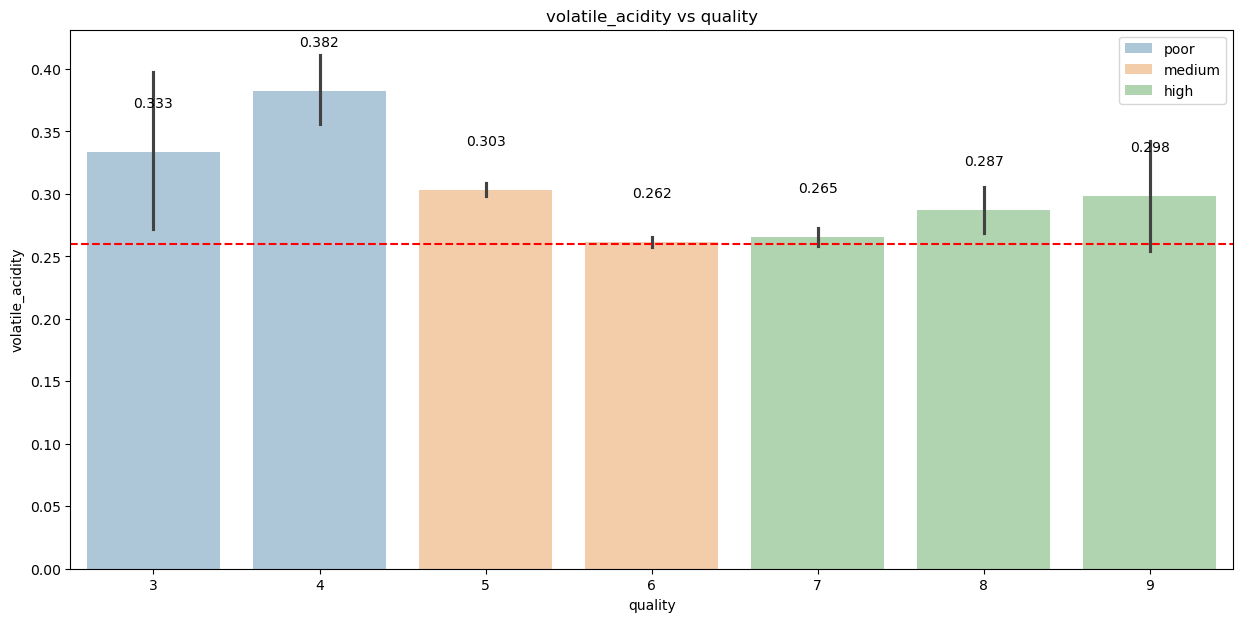

In [45]:
# quality vs volatile acidity
quality_predictor('volatile_acidity', 30)

* Poor quality wine has `volatile_acidity` value higher than the median value. This makes sense, since higher levels can lead to an unpleasant vinegar taste.

Broken red line (Median value): 0.04


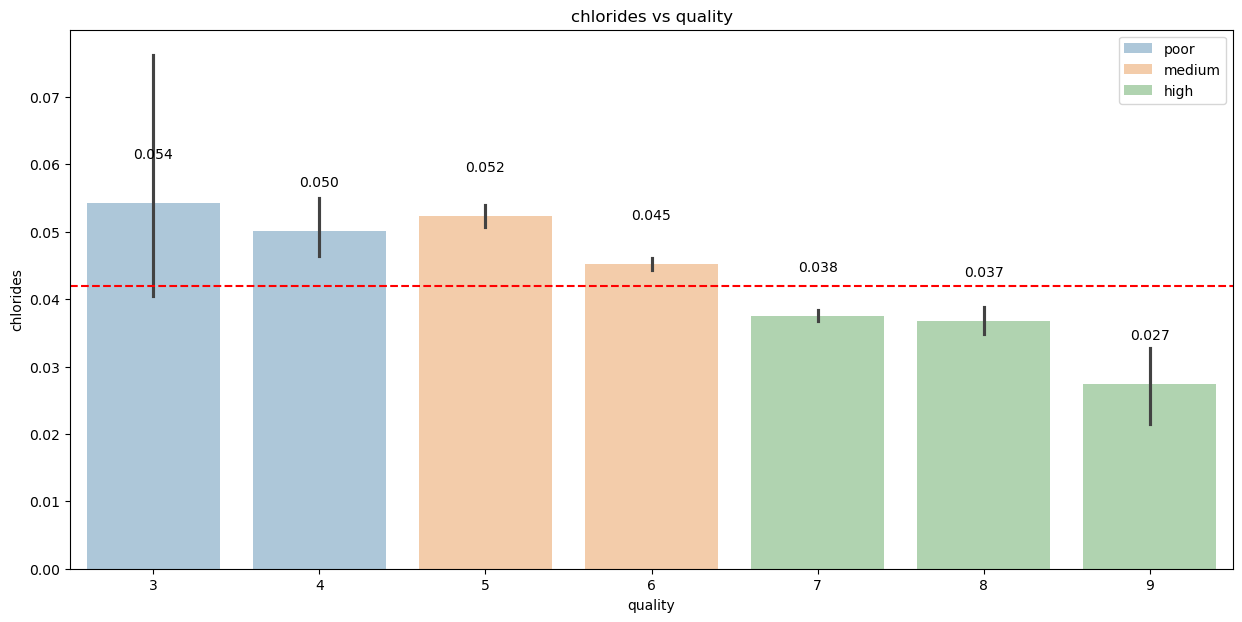

In [46]:
# chlorides vs quality
quality_predictor('chlorides', 30)

* High-quality wines have noticeably lower chlorides content. 

Broken red line (Median value): 0.32


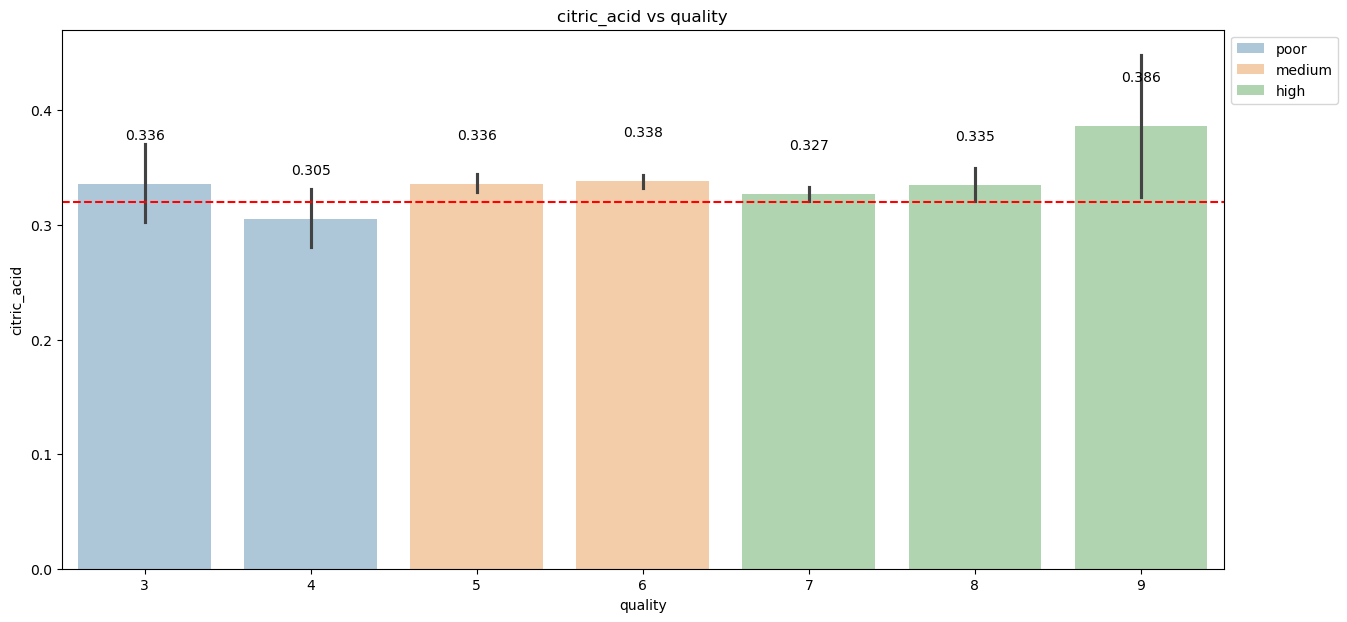

In [47]:
# fixed acidity , volatile acide, citric acid, quality
quality_predictor('citric_acid', 30)

Broken red line (Median value): 3.18


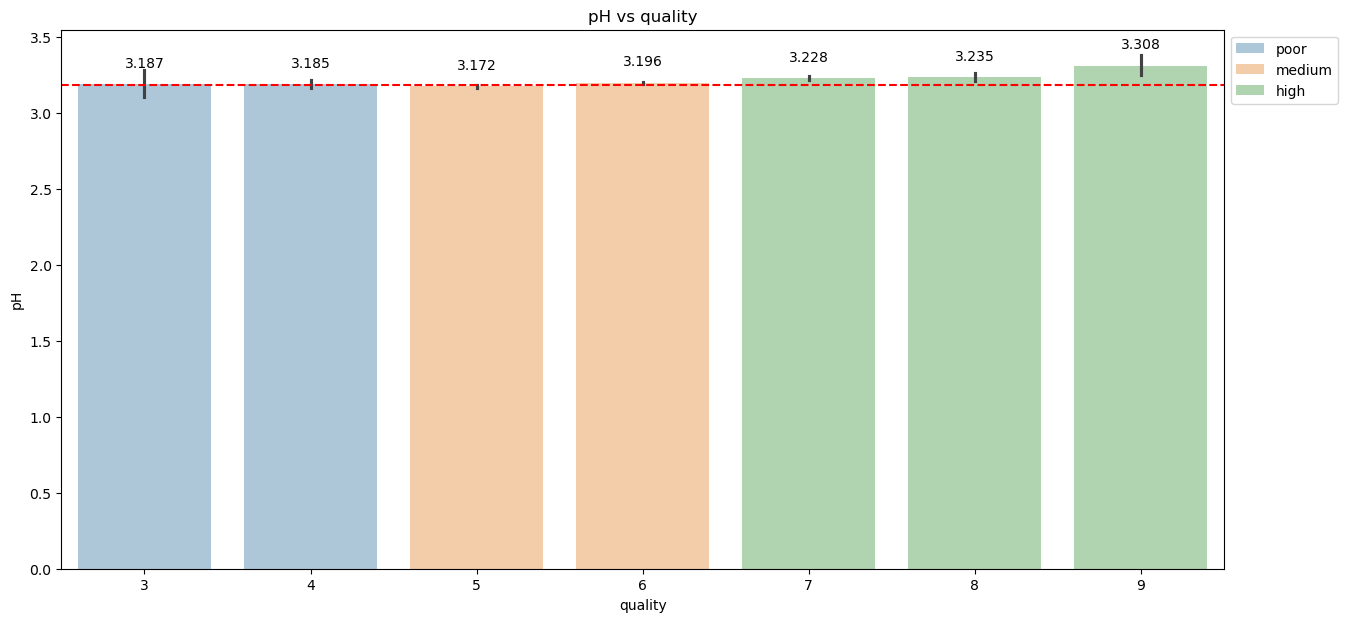

In [48]:
# pH vs quality
quality_predictor('pH', 10)

Note: Add in feature selection, total acids = volatile_acidity, fixed_acidity, citric_acid. 

In [49]:
# free sulfur dioxide and total sulfur dioxide, sulpahtes

In [50]:
# resid sugar, free and total sulfur dioxide

Broken red line (Median value): 4.70


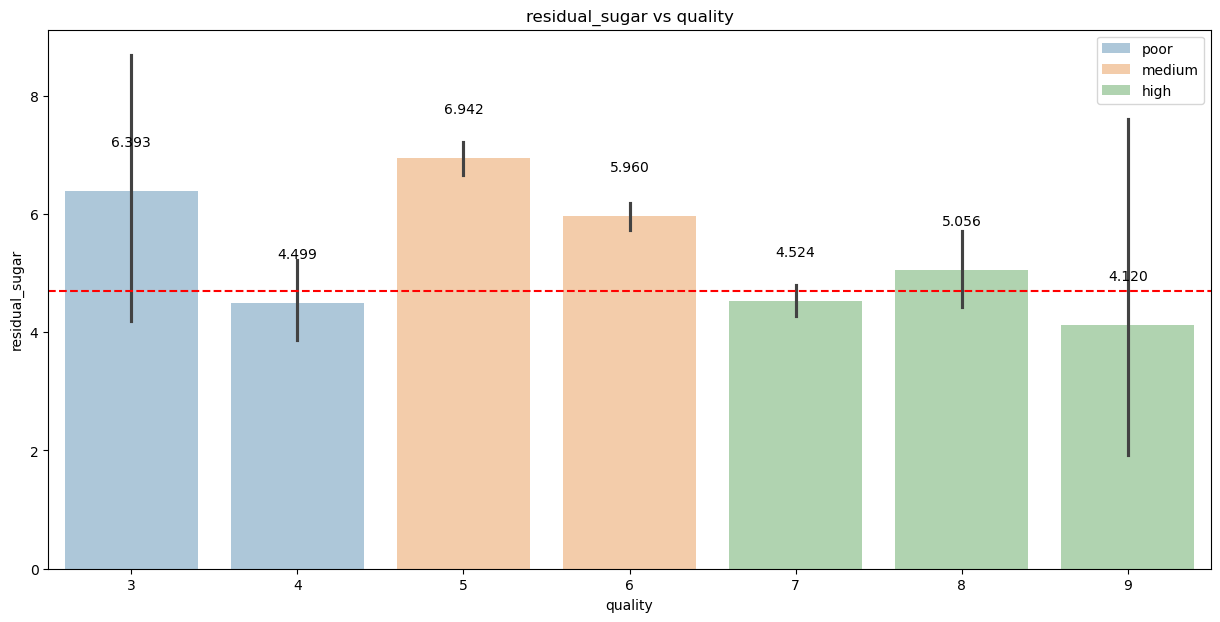

In [51]:
# resid sugar, quality
quality_predictor('residual_sugar', 30)

In [52]:
# density, total so2

In [53]:
# alc, free and total so2

### Insights from Exploratory Data Analysis:
* Use this information in deciding which feature standardization/normalization to be used:
    * Most features do not follow a normal distribution
    * Outliers are present

# **paCe: Construct Stage**
* Determine which models are most appropriate
* Construct the model
* Confirm model assumptions
* Evaluate model results to determine how well your model fits the data

## Step 3. Model Building

### Identify the type of prediction task
Using the X predictor variables/features, the target variable (*the quality of white wine*) that will be predicted is categorical and has three classes: `0 for poor`, `1 for medium`, and `2 for high`. This task involves **multiclass classification**.

### Identify the types of model most appropriate for this task
The models that are appropriate for this task are:
* Multiclass Logistic Regression
* Random Forest Classifier
* Extreme Gradient Boosting (XGBoost) Classifier
* Support Vector Machine (SVM) Classifier
* K-Nearest Neighbors (KNN) Classifier

### Model selection process: using **Nested Cross-validation**

Since the wine dataset is not very large, it would be most appropriate to split the data only into two sets, the train and test sets. Also, in order to get an idea of how the final model will perform on future unseen data, it is important that the test set will only be used using the champion model. 

![see diagram](nested_cv_diagram.png)  

* Nested cross-validation involves multiple splits of the data into training, validation, and test sets.
* In the inner loop, a model is fitted to each training set to approximately maximize the evaluation score, and then hyperparameters are optimized based on the validation set.
* In the outer loop, the model's performance is assessed by averaging the test set scores across various data splits.



Why choose model selection with nested cross-validation? 
> Model selection without nested cross-validation uses the same data to tune model parameters and evaluate model performance. Information may thus "leak" into the model and overfit the data. To avoid this, a nested cross-validation will be used in this project.[^3]

[^3]: Nested versus non-nested cross-validation. Scikit-learn. https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 


### Modeling Workflow
1. Split the data into train and test sets (80/20).
2. Execute the nested cross-validation using the original train set.
3. Select the champion model based on its performance on the outer loop of the nested cross-validation.
4. Get the best parameters of the champion model using GridSearchCV and train the champion model using the entire train set.
5. Assess the champion model's performance on the test set.

### Identify the evaluation metrics to evaluate the models _ specify if macro, micro, weighted
* **F1 score** will be used to evaluate the performance of the selection of models. F1 score is the balance between precision (*minimizes false positive*) and recall (*minimizes false negative*).  
* F1 score is the most appropriate metric to use given that the dataset is imbalanced because the f1 score takes into account the type of errors&mdash;false positive and false negative, not just the number of predictions that were incorrect.
* For a multi-class classification problem, f1 score is calculated per class in a one-vs-the-rest manner. In this approach, each class's success is rated separately, as if there are distinct classifiers for each class.
* A high f1 score means the model is able to classify positive instances of a class accurately while minimizing false positives and false negatives.

* `macro`, `micro`, `weighted`
    * [`weighted`](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/24051#24051) = the output average would be accounted 
    *  `micro`= the evaluation metrics will be equal to each other
    *  `macro` = treats the classes equally regardless of the number of actual occurrences of the class in the dataset.



Note that in **macro averaging**, all classes get equal weight when contributing their portion of the precision value to the total. This might not be a realistic calculation when you have a large amount of class imbalance. In that case, a **weighted macro** average might make more sense


### Model assumptions

#### Logistic regression model assumptions
- [x] Outcome variable is categorical
- [x] Observations are independent of each other
- [x] No severe multicollinearity among X variables
- [x] No extreme outliers
- [x] Linear relationship between each X variable and the logit of the outcome variable
- [x] Sufficiently large sample size

#### Other assumptions: 
-  Other models such as K-nearest neighbors and support vector machines are much more sensitive to attributes with skewed distributions or outliers.
-  Some models, notably support vector machines, are sensitive to irrelevant attributes.

### Preprocessing
* Consider what would be the effect of the pre-processing on the issue of data leakage# Label encode the quality_class

In [54]:
# Label encode the quality_class
df = df.copy()  # To eliminate the SettingWithCopyWarning
df['quality_cat_code'] = df['quality_cat'].astype('category').cat.set_categories(
    ['poor', 'medium', 'high']).cat.codes

df['quality_cat_code'].value_counts(normalize=True)

quality_cat_code
1    0.748043
2    0.208281
0    0.043676
Name: proportion, dtype: float64

### Modeling Round 1: Including all the features

In [105]:
# Split the data into train and test sets 
X = df.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1)
y = df['quality_cat_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

# Check the split
for x in [X_train, X_test, y_train, y_test]: 
    print(len(x))

3168
793
3168
793


In [106]:
X.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [107]:
y.value_counts()

quality_cat_code
1    2963
2     825
0     173
Name: count, dtype: int64

In [108]:
# Initialize the algorithm
logreg = LogisticRegression(multi_class='multinomial', random_state=42)
knn = KNeighborsClassifier(algorithm='ball_tree')
svm = SVC(random_state=42, probability=True)
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
rf = RandomForestClassifier(random_state=42)

In [109]:
# Build pipelines for data preprocessing
pipe_logreg = Pipeline([('scaler', StandardScaler()),
                        ('logreg', logreg)])

pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('knn', knn)])

pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm)])

# Get the parameter to be used in parameter grids
pipe_svm.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('svm', SVC(probability=True, random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'svm': SVC(probability=True, random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'svm__C': 1.0,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probability': True,
 'svm__random_state': 42,
 'svm__shrinking': True,
 'svm__tol': 0.001,
 'svm__verbose': False}

In [110]:
# Set up hyperparameters
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4,4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3,30,2)),
                   'knn__p': [1,2]}]


param_grid_svm = [{'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1,2))}]

param_grid_xgb = [{'max_depth': [3, 5, 9],
                   'min_child_weight': [1, 3, 5],
                   'subsample': [0.8],
                   'colsample_bytree': [0.8], 
                   'learning_rate': [0.01, 0.1],
                   'num_class': [3],
                   'n_estimators': [100, 300]}]

param_grid_rf = [{'max_depth': [6, 9, 12],
                  'max_features': [1.0],
                  'max_samples': [0.7, 1.0],
                  'min_samples_leaf': [1, 3, 5],
                  'min_samples_split': [2, 4, 6],
                  'n_estimators': [100, 300, 500]}]

In [111]:
# Set Scoring
scoring=['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [74]:
# Set up the multiple GridSearchCV for the inner loop
gridcv = {}
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for pgrid, est, name in zip((param_grid_logreg, param_grid_knn, param_grid_svm,
                             param_grid_xgb, param_grid_rf),
                            (pipe_logreg, pipe_knn, pipe_svm, xgb, rf),
                            ('LogReg', 'KNN', 'SVM', 'XGBoost', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=-1,
                       cv=inner_cv,
                       error_score='raise',
                       refit='f1_weighted')
    gridcv[name] = gcv



In [75]:
# Set up the outer loop for model selection
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, gs_est in sorted(gridcv.items()):
    scores_dict = cross_validate(gs_est, 
                                X=X_train,
                                y=y_train, 
                                scoring=scoring,
                                cv=outer_cv,
                                return_estimator=True,
                                error_score='raise',
                                n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('     Inner loop:')


    for i in range(scores_dict['test_f1_weighted'].shape[0]):    
        print('\n         Best F1: (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('         Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('         F1: (on outer test fold) %.2f%%' % (scores_dict['test_f1_weighted'][i]*100))

    print('\n%s | outer F1: %.2f%% +/- %.2f' %
          (name, scores_dict['test_f1_weighted'].mean() * 100,
           scores_dict['test_f1_weighted'].std() * 100))

    print('\nSUMMARY OF OUTER SCORES:')
    print(pd.DataFrame({'model': [name],
                        'precision': [scores_dict['test_precision_weighted'].mean()],
                        'recall': [scores_dict['test_recall_weighted'].mean()],
                        'F1': [scores_dict['test_f1_weighted'].mean()],
                        'accuracy': [scores_dict['test_balanced_accuracy'].mean()]
                       }))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 73.66%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=4))])
         F1: (on outer test fold) 74.73%

         Best F1: (avg. of inner test folds) 75.36%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=9))])
         F1: (on outer test fold) 74.79%

         Best F1: (avg. of inner test folds) 73.88%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors

In [112]:
# use pickle to save the fitted models
path = 'pickled_models'

In [113]:
# function to write the pickle
def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [114]:
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read: 
        model = pickle.load(to_read)
    return model

**4. Get the best parameters of the champion model using GridSearchCV and train the champion model using the entire train set.**

In [115]:
# Helper function to get the best hyperparameter of the champion model
def champion_gcv(est, param_grid):
    champion_model = GridSearchCV(estimator=est,
                                  param_grid=param_grid,
                                  scoring=scoring,
                                  n_jobs=-1,
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                  verbose=1,
                                  error_score='raise',
                                  refit='f1_weighted')
    return champion_model

In [116]:
# Get the best hyperparameter of the champion model 
champion_model = champion_gcv(xgb, param_grid_xgb)

In [78]:
# Train the model using X_train, y_train
%%time
champion_model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 5.62 s
Wall time: 1min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy...
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid=[{'colsample_bytree': [0.8],
                          'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 9],
                          'min_child_weight': [1, 3, 5],
                          'n_estimators': [100, 300], 'num_class': [3],
                          'subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [83]:
# Save the model
write_pickle(path, champion_model, 'champion_model_round1')

In [117]:
# Read the pickle
champion_model = read_pickle(path, 'champion_model_round1')

In [118]:
champion_model.best_score_

0.7624796706406716

In [119]:
champion_model.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 300,
 'num_class': 3,
 'subsample': 0.8}

In [120]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments: 
        model_name (string): what you want the model to be called in the output table
        model_object       : a fit GridSearchCV object
        metric (string)    : precision, recall, f1, accuracy, or roc_auc

    Return a pandas dataframe with the precision, recall, f1, accuracy, and roc_auc scores
    for the model with the best mean 'metric' score across all validation folds
    '''
    # Create a dictionary that maps input metric to actual metric name in the GridSearchCV
    metric_dict = {'precision': 'mean_test_precision_weighted',
                   'recall': 'mean_test_recall_weighted',
                   'f1': 'mean_test_f1_weighted', 
                   'accuracy': 'mean_test_balanced_accuracy'}
    
    # Get all the results from the CV and put them in a dataframe
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the dataframe with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]
    
    # Extract precision, recall, f1, accuracy, roc_auc scores from that row
    precision = best_estimator_results.mean_test_precision_weighted
    recall = best_estimator_results.mean_test_recall_weighted
    f1 = best_estimator_results.mean_test_f1_weighted
    accuracy = best_estimator_results.mean_test_balanced_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy]
                         })
    
    return table

In [121]:
def get_scores(model_name:str, model, X_test_data, y_test_data): 
    '''
    Generates a table of test scores.

    Arguments: 
        model_name (string): How you want your model to be named in the output table 
        model:               A fit GridSearchCV object
        X_test_data:         numpy array of X_test_data
        y_test_data:         numpy array of y_test_data

    Return: pandas DataFrame of precision, recall, f1, accuracy, and roc_auc scores 
    '''

    preds = model.best_estimator_.predict(X_test_data)

    precision = precision_score(y_test_data, preds, average='weighted')
    recall = recall_score(y_test_data, preds, average='weighted')
    f1 = f1_score(y_test_data, preds, average='weighted')
    accuracy = balanced_accuracy_score(y_test_data, preds)


   # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy]
                         })
    
    return table

In [122]:
# Assess the performance of the model during validation
champion_model_results = make_results('Champion_1 val', champion_model, 'f1')
champion_model_results

,model,precision,recall,f1,accuracy
0,Champion_1 val,0.762259,0.785353,0.76248,0.490853


In [123]:
# Assess the performance of the model using the test set
champion_model_test_scores = get_scores('Champion_1 test', champion_model, X_test, y_test)
champion_model_test_scores

,model,precision,recall,f1,accuracy
0,Champion_1 test,0.780649,0.796974,0.77784,0.516711


In [124]:
# Summarize the results
results = pd.concat([champion_model_results, champion_model_test_scores], axis=0)
results

,model,precision,recall,f1,accuracy
0,Champion_1 val,0.762259,0.785353,0.76248,0.490853
0,Champion_1 test,0.780649,0.796974,0.77784,0.516711


In [125]:
# Helper function to create a confusion matrix function
def confusion_matrix_displayer(model_name, X_test_data, y_test_data, matrix_name:str):
    '''
    Input: 
        champion_model:        model_object
        X_test_data:           numpy array of X_test_data
        y_test_data:           numpy array of y_test_data
        matrix_name (string):  how you want you confusion matrix to be named
    '''
    test_preds = model_name.best_estimator_.predict(X_test_data)
    labels = ['poor', 'medium', 'high']

    cm = confusion_matrix(y_test_data, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.title(f'{matrix_name}')
    plt.savefig(f'{matrix_name}.png')
    plt.show()

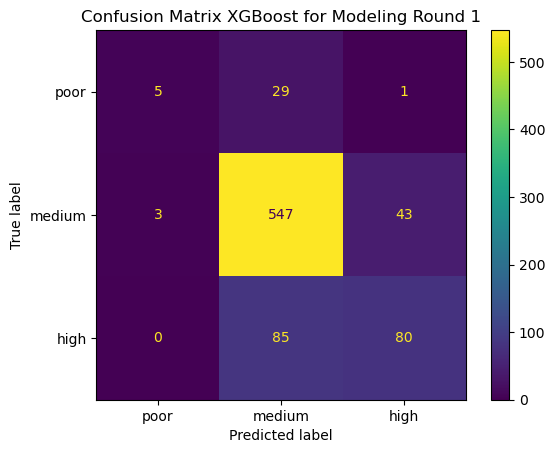

In [126]:
# Plot the confusion matrix
confusion_matrix_displayer(champion_model, X_test, y_test, 'Confusion Matrix XGBoost for Modeling Round 1')

In [127]:
y_test.value_counts()

quality_cat_code
1    593
2    165
0     35
Name: count, dtype: int64

* The model was able to correctly classify (92%) *547* medium wines out of the actual *593* medium-quality wines.
* The model was able to correctly classify (14%) *5* poor wines out of the actual *35* poor-quality wines.
* The model was able to correctly classify (48%) *80* high-quality wines of the actual *165* high-quality wines. 

In [128]:
# Helper function to plot the important features using XGBoost model
def importance_plotter(model, feature_name:str):
    ax = plot_importance(model.best_estimator_)
    ax.set_title(f'{feature_name}')
    ax.figure.tight_layout()
    ax.figure.savefig(f'{feature_name}.png')
    plt.show()

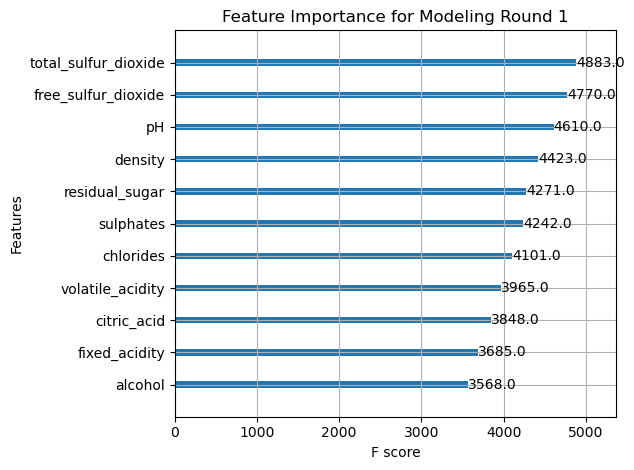

In [129]:
# Plot feature importance to reveal the strong predictors of the target variable
importance_plotter(champion_model, 'Feature Importance for Modeling Round 1')

### Modeling Round 2: Using Feature Engineering

#### Feature Engineering

#### Feature selection and Feature extraction
try this: ['residual sugar', 'total sulfur dioxide', 'sulphates',
                   'alcohol', 'volatile acidity', 'quality']

#### Feature selection
try this: alcohol, volatile acidity, total so2, chlorides, resid sugar, sulphates, pH

In [144]:
# Adding new features
df1 = df.copy()

In [145]:
df1['total_acids'] = df1['fixed_acidity'] + df1['volatile_acidity'] + df1['citric_acid']
df1['total_acids_pH_ratio'] = df1['total_acids'] / df1['pH']
df1['resid_sugar_alc_ratio'] = df1['residual_sugar'] / df1['alcohol']

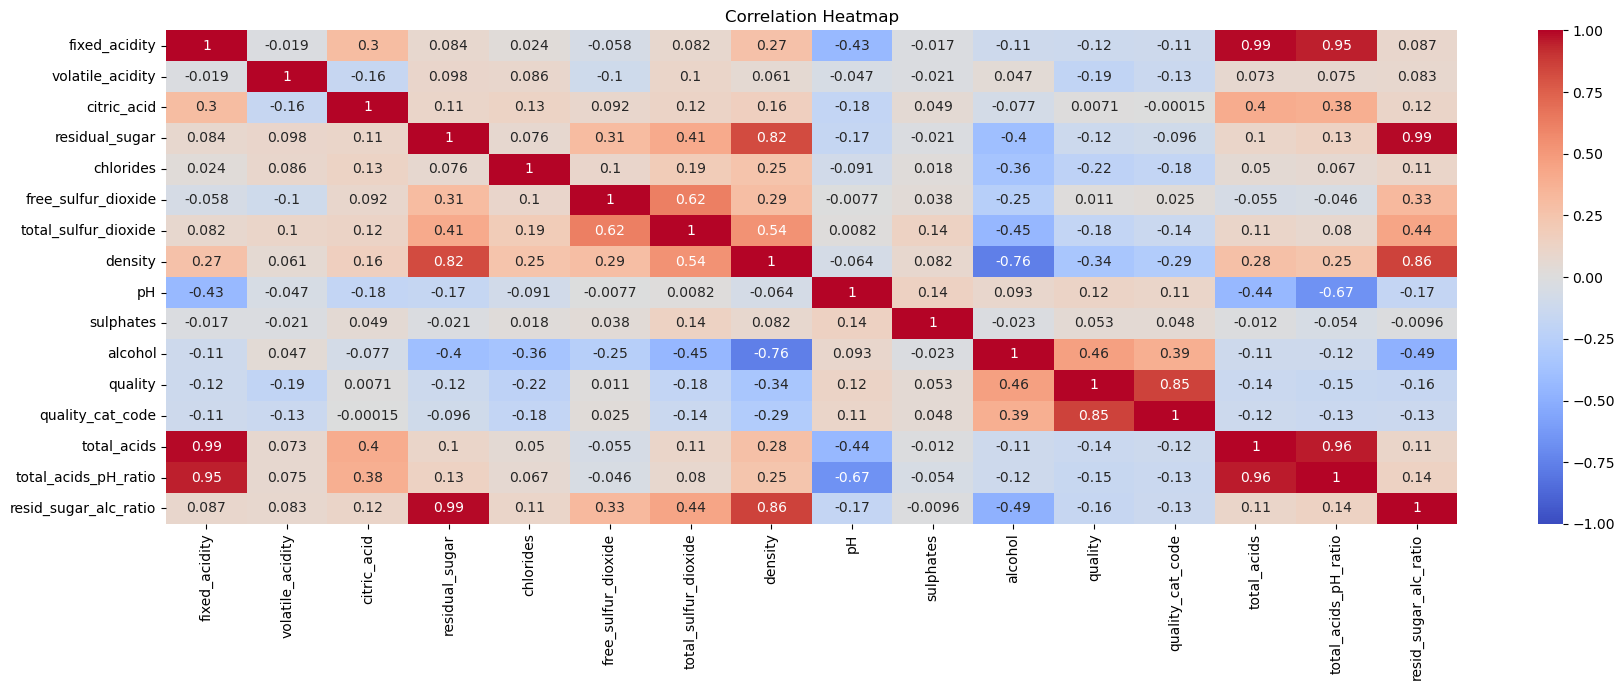

In [146]:
# Plot a correlation heatmap
plt.figure(figsize=(18,7))
fig = sns.heatmap(df1.corr(method='pearson', numeric_only=True), vmin=-1,
                 vmax=1, annot=True, cmap='coolwarm')
fig.set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('corrmap2.png')
plt.show()

In [147]:
# Feature selection
X1 = df1.drop(columns=['quality', 'total_acids', 'quality_cat', 'quality_cat_code', 'fixed_acidity', 'citric_acid', 'density', 'residual_sugar', 'free_sulfur_dioxide'], axis=1) 
y1 = df1['quality_cat_code']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,
                                                   stratify=y1, random_state=1)

# Check the train/test sets
for x in [X1_train, X1_test, y1_train, y1_test]:
    print(len(x))

# Inspect the variables
X1.head()

3168
793
3168
793


,volatile_acidity,chlorides,total_sulfur_dioxide,pH,sulphates,alcohol,total_acids_pH_ratio,resid_sugar_alc_ratio
0,0.27,0.045,170.0,3.00,0.45,8.8,2.543333,2.352273
1,0.30,0.049,132.0,3.30,0.49,9.5,2.103030,0.168421
2,0.28,0.050,97.0,3.26,0.44,10.1,2.693252,0.683168
3,0.23,0.058,186.0,3.19,0.40,9.9,2.429467,0.858586
6,0.32,0.045,136.0,3.18,0.47,9.6,2.100629,0.729167


##### Using the same initialization, param grids, scoring as modeling round 1

In [95]:
# Set up the multiple GridSearchCV for the inner loop
gridcv = {}
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for pgrid, est, name in zip((param_grid_logreg, param_grid_knn, param_grid_svm,
                             param_grid_xgb, param_grid_rf),
                            (pipe_logreg, pipe_knn, pipe_svm, xgb, rf),
                            ('LogReg', 'KNN', 'SVM', 'XGBoost', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=-1,
                       cv=inner_cv,
                       error_score='raise',
                       refit='f1_weighted')
    gridcv[name] = gcv

In [96]:
# Set up the outer loop for model selection
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, gs_est in sorted(gridcv.items()):
    scores_dict = cross_validate(gs_est, 
                                X=X1_train,
                                y=y1_train, 
                                scoring=scoring,
                                cv=outer_cv,
                                return_estimator=True,
                                error_score='raise',
                                n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('     Inner loop:')


    for i in range(scores_dict['test_f1_weighted'].shape[0]):    
        print('\n         Best F1: (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('         Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('         F1: (on outer test fold) %.2f%%' % (scores_dict['test_f1_weighted'][i]*100))

    print('\n%s | outer F1: %.2f%% +/- %.2f' %
          (name, scores_dict['test_f1_weighted'].mean() * 100,
           scores_dict['test_f1_weighted'].std() * 100))

    print('\nSUMMARY OF OUTER SCORES:')
    print(pd.DataFrame({'model': [name],
                        'precision': [scores_dict['test_precision_weighted'].mean()],
                        'recall': [scores_dict['test_recall_weighted'].mean()],
                        'F1': [scores_dict['test_f1_weighted'].mean()],
                        'accuracy': [scores_dict['test_balanced_accuracy'].mean()]
                       }))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 74.16%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 74.74%

         Best F1: (avg. of inner test folds) 72.96%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=13))])
         F1: (on outer test fold) 76.93%

         Best F1: (avg. of inner test folds) 74.99%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 72.28%

         Best F1: (avg. of inner test folds) 73.36%
    

In [99]:
# Get the best hyperparameters of the champion model
champion_model2 = champion_gcv(xgb, param_grid_xgb)

In [101]:
# using X=X1_train,y=y1_train
%%time
champion_model2.fit(X1_train, y1_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy...
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid=[{'colsample_bytree': [0.8],
                          'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 9],
                          'min_child_weight': [1, 3, 5],
                          'n_estimators': [100, 300], 'num_class': [3],
                          'subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [102]:
# Save the model
write_pickle(path, champion_model2, 'champion_model_round2')

In [140]:
# Read the pickle
champion_model2 = read_pickle(path, 'champion_model_round2')

In [141]:
champion_model2.best_score_

0.7584652885810179

In [142]:
# Assess the performance of the model during validation
champion_model_results2 = make_results('Champion_2 val', champion_model2, 'f1')
champion_model_results2

,model,precision,recall,f1,accuracy
0,Champion_2 val,0.755184,0.781887,0.758465,0.478868


In [148]:
# Assess the performance of the model using the # using X=X1_test,y=y1_test
champion_model_test_scores2 = get_scores('Champion_2 test', champion_model2, X1_test, y1_test)
champion_model_test_scores2

,model,precision,recall,f1,accuracy
0,Champion_2 test,0.740301,0.769231,0.745625,0.472054


In [149]:
# Summarize the results
results = pd.concat([results, champion_model_results2, champion_model_test_scores2], axis=0)
results

,model,precision,recall,f1,accuracy
0,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,Champion_2 val,0.755184,0.781887,0.758465,0.478868
0,Champion_2 test,0.740301,0.769231,0.745625,0.472054


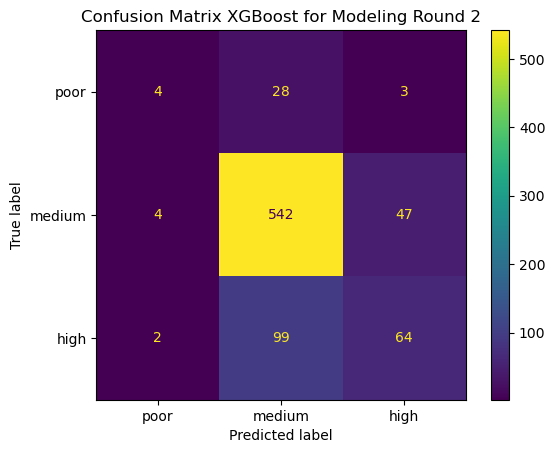

In [150]:
# Plot the confusion matrix
confusion_matrix_displayer(champion_model2, X1_test, y1_test, 'Confusion Matrix XGBoost for Modeling Round 2')

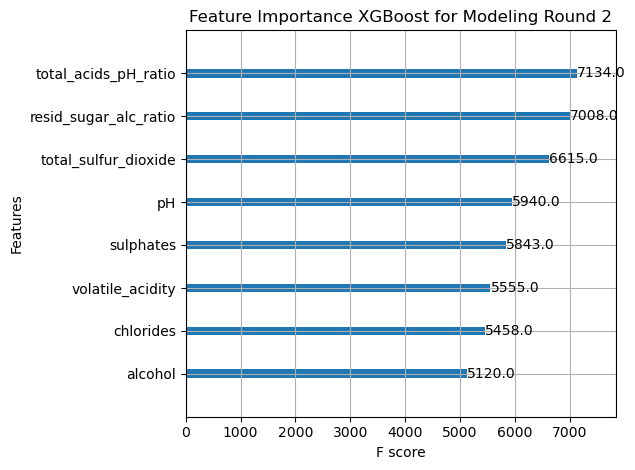

In [151]:
# Plot feature importance to reveal the strong predictors of the target variable
importance_plotter(champion_model2, 'Feature Importance XGBoost for Modeling Round 2')

### Modeling Round 3: Addressing the class imbalance using SMOTE
**NOTE:**
* Apply SMOTE only in training data but not the validation or test data: When using cross-validation, do not SMOTE the data before sending it in to the nested cross-validation process.  

In [152]:
# Adding new features
df2 = df.copy()
# Feature selection
X2 = df2.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1) 
y2 = df2['quality_cat_code']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,
                                                   stratify=y2, random_state=7)

# Check the train/test sets
for x in [X2_train, X2_test, y2_train, y2_test]:
    print(len(x))

# Inspect the variables
X2.head()

3168
793
3168
793


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6


In [138]:
# Initialize the algorithm
logreg = LogisticRegression(multi_class='multinomial', random_state=42)
knn = KNeighborsClassifier(algorithm='ball_tree')
svm = SVC(random_state=42, probability=True)
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
rf = RandomForestClassifier(random_state=42)

In [139]:
# Build pipelines for data preprocessing
pipe_logreg = imbpipeline(steps = [('scale', StandardScaler()),
                                   ('over', SMOTE(random_state=42)),
                                   ('logreg', logreg)])


pipe_knn = imbpipeline(steps = [('scale', StandardScaler()),
                                ('over', SMOTE(random_state=42)),
                                ('knn', knn)])

pipe_svm = imbpipeline(steps = [('scale', StandardScaler()),
                                ('over', SMOTE(random_state=42)),
                                ('svm', svm)])

pipe_xgb = imbpipeline(steps = [('over', SMOTE(random_state=42)),
                                ('xgb', xgb)])

pipe_rf = imbpipeline(steps = [('over', SMOTE(random_state=42)),
                               ('rf', rf)])

In [140]:
# Set up the parameter grids for hyperparameter tuning
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4, 4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3, 30,2)),
                   'knn__p': [1, 2]}]

param_grid_svm = [{'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1, 2))}]

param_grid_xgb = [{'xgb__max_depth': [3, 5, 9], 
                   'xgb__min_child_weight': [1, 3, 5],
                   'xgb__subsample': [0.8],
                   'xgb__colsample_bytree': [0.8],
                   'xgb__learning_rate': [0.01, 0.1],
                   'xgb__num_class': [3],
                   'xgb__n_estimators': [100, 300]}]

param_grid_rf = [{'rf__max_depth': [6, 9, 12], 
                  'rf__max_features': [1.0],
                  'rf__max_samples': [0.7, 1.0],
                  'rf__min_samples_leaf': [1, 3, 5],
                  'rf__min_samples_split': [2, 4, 6],
                  'rf__n_estimators': [100, 300, 500]}]

In [141]:
# Set up the multiple GridSearchCV for the inner loop
gridcv = {}
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for pgrid, est, name in zip((param_grid_logreg, param_grid_knn, param_grid_svm,
                             param_grid_xgb, param_grid_rf),
                            (pipe_logreg, pipe_knn, pipe_svm, pipe_xgb, pipe_rf),
                            ('LogReg', 'KNN', 'SVM', 'XGBoost', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=-1,
                       cv=inner_cv,
                       error_score='raise',
                       refit='f1_weighted')
    gridcv[name] = gcv

In [142]:
# Set up the outer loop for model selection
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, gs_est in sorted(gridcv.items()):
    scores_dict = cross_validate(gs_est, 
                                X=X2_train,
                                y=y2_train, 
                                scoring=scoring,
                                cv=outer_cv,
                                return_estimator=True,
                                error_score='raise',
                                n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('     Inner loop:')


    for i in range(scores_dict['test_f1_weighted'].shape[0]):    
        print('\n         Best F1: (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('         Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('         F1: (on outer test fold) %.2f%%' % (scores_dict['test_f1_weighted'][i]*100))

    print('\n%s | outer F1: %.2f%% +/- %.2f' %
          (name, scores_dict['test_f1_weighted'].mean() * 100,
           scores_dict['test_f1_weighted'].std() * 100))

    print('\nSUMMARY OF OUTER SCORES:')
    print(pd.DataFrame({'model': [name],
                        'precision': [scores_dict['test_precision_weighted'].mean()],
                        'recall': [scores_dict['test_recall_weighted'].mean()],
                        'F1': [scores_dict['test_f1_weighted'].mean()],
                        'accuracy': [scores_dict['test_balanced_accuracy'].mean()]
                       }))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 64.00%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3, p=1))])
         F1: (on outer test fold) 65.88%

         Best F1: (avg. of inner test folds) 64.97%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3, p=1))])
         F1: (on outer test fold) 67.59%

         Best F1: (avg. of inner test folds) 64.42%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
               

In [192]:
# Get the best hyperparameters of the champion model
champion_model3 = champion_gcv(pipe_xgb, param_grid_xgb)

In [193]:
%%time
champion_model3.fit(X2_train, y2_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 6.83 s
Wall time: 2min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval...
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid=[{'xgb__colsample_bytree': [0.8],
                          'xgb__learning_rate': [0.01, 0.1],
                          'xgb__max_depth': [3, 5, 9],
                          'xgb__min_child_weight': [1, 3, 5],
                          'xgb__n_estimators': [100, 300],
                          'xgb__num_class': [3], 'xgb__subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [194]:
# Save the model
write_pickle(path, champion_model3, 'champion_model_round3')

In [153]:
# Read the pickle
champion_model3 = read_pickle(path, 'champion_model_round3')

In [154]:
champion_model3.best_score_

0.7647139155333414

In [155]:
champion_model3.best_params_

{'xgb__colsample_bytree': 0.8,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 9,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 300,
 'xgb__num_class': 3,
 'xgb__subsample': 0.8}

In [156]:
# Assesss the performance of the model during validation
champion_model_results3 = make_results('Champion_3 val', champion_model3, 'f1')
champion_model_results3

,model,precision,recall,f1,accuracy
0,Champion_3 val,0.762146,0.768308,0.764714,0.575687


In [157]:
# Assess the performance of the model using X2_test, y2_test
champion_model_test_scores3 = get_scores('Champion_3 test', champion_model3, X2_test, y2_test)
champion_model_test_scores3

,model,precision,recall,f1,accuracy
0,Champion_3 test,0.76485,0.774275,0.768106,0.558692


In [158]:
# Summarize the results
results = pd.concat([results, champion_model_results3, champion_model_test_scores3], axis=0)
results

,model,precision,recall,f1,accuracy
0,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,Champion_2 val,0.755184,0.781887,0.758465,0.478868
0,Champion_2 test,0.740301,0.769231,0.745625,0.472054
0,Champion_3 val,0.762146,0.768308,0.764714,0.575687
0,Champion_3 test,0.764850,0.774275,0.768106,0.558692


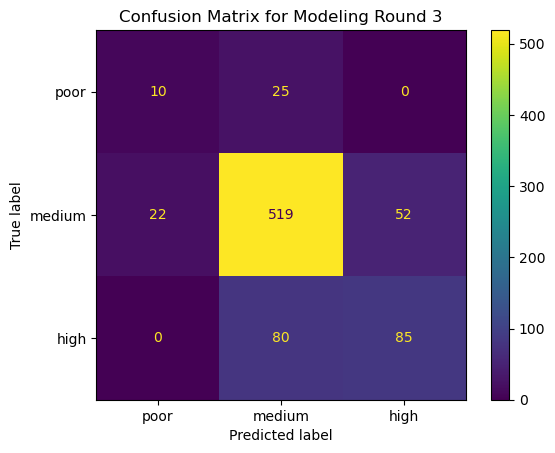

In [159]:
# Plot the confusion matrix
confusion_matrix_displayer(champion_model3, X2_test, y2_test, 'Confusion Matrix for Modeling Round 3')

In [161]:
# Plot the feature importance from pipeline
champion_xgb_pipeline = champion_model3.best_estimator_
xgb_model = champion_xgb_pipeline.named_steps['xgb']

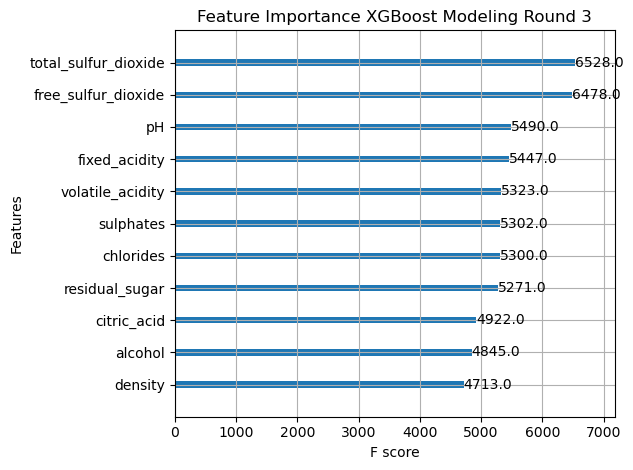

In [162]:
ax = plot_importance(xgb_model)
ax.set_title('Feature Importance XGBoost Modeling Round 3')
ax.figure.tight_layout()
ax.figure.savefig('Feature Importance XGBoost Modeling Round 3.png')
plt.show()

### Modeling Round 4: Assign class weights to penalize miscalculations of the minority class more

In [95]:
from sklearn.utils.class_weight import compute_class_weight

In [96]:
df3 = df.copy()
# Split your data
X3 = df3.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1) 
y3 = df3['quality_cat_code']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2,
                                                   stratify=y3, random_state=14)

# Check the train/test sets
for x in [X3_train, X3_test, y3_train, y3_test]:
    print(len(x))

3168
793
3168
793


In [97]:
# Calcualte the class weights for multi-class classification
classes = np.unique(y3)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y3)
class_weight_dict = dict(zip(classes, class_weights))

In [98]:
# Initialize the algorithm
logreg = LogisticRegression(multi_class='multinomial', random_state=42, class_weight='balanced')
knn = KNeighborsClassifier(algorithm='ball_tree', weights='distance')
svm = SVC(random_state=42, probability=True, class_weight='balanced')
xgb = XGBClassifier(objective='multi:softmax', random_state=42, eval_metric='mlogloss')   # Try class weights

In [99]:
# Build pipelines for data preprocessing
pipe_logreg = Pipeline(steps = [('scale', StandardScaler()),
                                ('logreg', logreg)])

pipe_knn = Pipeline(steps = [('scale', StandardScaler()),
                             ('knn', knn)])

pipe_svm = Pipeline(steps = [('scale', StandardScaler()),
                             ('svm', svm)])

In [100]:
# Set up the parameter grids for hyperparameter tuning
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4, 4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3, 30,2)),
                   'knn__p': [1, 2]}]
                   
                   

param_grid_svm = [{ 'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1, 2))}]
                   

param_grid_xgb = [{'max_depth': [3, 5, 9], 
                   'min_child_weight': [1, 3, 5],
                   'subsample': [0.8],
                   'colsample_bytree': [0.8],
                   'learning_rate': [0.01, 0.1],
                   'num_class': [3],
                   'scale_pos_weight': [class_weights[i] for i in classes], 
                   'n_estimators': [100, 300]}]   

In [101]:
# Set up the multiple GridSearchCV for the inner loop
gridcv = {}
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for pgrid, est, name in zip((param_grid_logreg, param_grid_knn, 
                             param_grid_svm, param_grid_xgb),
                            (pipe_logreg, pipe_knn, pipe_svm, xgb),
                            ('LogReg', 'KNN', 'SVM', 'XGBoost')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=-1,
                       cv=inner_cv,
                       error_score='raise',
                       refit='f1_weighted')
    gridcv[name] = gcv

In [102]:
# Set up the outer loop for model selection using X3_train, y3_train
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, gs_est in sorted(gridcv.items()):
    scores_dict = cross_validate(gs_est, 
                                X=X3_train,
                                y=y3_train, 
                                scoring=scoring,
                                cv=outer_cv,
                                return_estimator=True,
                                error_score='raise',
                                n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('     Inner loop:')


    for i in range(scores_dict['test_f1_weighted'].shape[0]):    
        print('\n         Best F1: (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('         Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('         F1: (on outer test fold) %.2f%%' % (scores_dict['test_f1_weighted'][i]*100))

    print('\n%s | outer F1: %.2f%% +/- %.2f' %
          (name, scores_dict['test_f1_weighted'].mean() * 100,
           scores_dict['test_f1_weighted'].std() * 100))

    print('\nSUMMARY OF OUTER SCORES:')
    print(pd.DataFrame({'model': [name],
                        'precision': [scores_dict['test_precision_weighted'].mean()],
                        'recall': [scores_dict['test_recall_weighted'].mean()],
                        'F1': [scores_dict['test_f1_weighted'].mean()],
                        'accuracy': [scores_dict['test_balanced_accuracy'].mean()]
                       }))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 74.70%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=7, weights='distance'))])
         F1: (on outer test fold) 74.40%

         Best F1: (avg. of inner test folds) 74.16%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=13, p=1,
                                      weights='distance'))])
         F1: (on outer test fold) 75.74%

         Best F1: (avg. of inner test folds) 74.90%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algor

In [130]:
# Get the best hyperparameters of the champion model
champion_model4 = champion_gcv(xgb, param_grid_xgb)

In [131]:
# using X=X1_train,y=y1_train
champion_model4.fit(X3_train, y3_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy...
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid=[{'colsample_bytree': [0.8],
                          'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 9],
                          'min_child_weight': [1, 3, 5],
                          'n_estimators': [100, 300], 'num_class': [3],
                          'subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [137]:
# Save the model
write_pickle(path, champion_model4, 'champion_model_round4')

In [138]:
# Read the pickle
champion_model4 = read_pickle(path, 'champion_model_round4')

In [139]:
champion_model4.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 100,
 'num_class': 3,
 'subsample': 0.8}

In [163]:
# Assess the performance of the model during validation
champion_model_results4 = make_results('Champion_4 val', champion_model4, 'f1')
champion_model_results4

,model,precision,recall,f1,accuracy
0,Champion_4 val,0.763124,0.781876,0.756688,0.480364


In [164]:
# Assess the performance of the model using the test set
champion_model_test_scores4 = get_scores('Champion_4 test', champion_model4, X3_test, y3_test)
champion_model_test_scores4

,model,precision,recall,f1,accuracy
0,Champion_4 test,0.748601,0.774275,0.748048,0.47889


In [165]:
# Summarize the results
results = pd.concat([results, champion_model_results4, champion_model_test_scores4], axis=0)
results

,model,precision,recall,f1,accuracy
0,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,Champion_2 val,0.755184,0.781887,0.758465,0.478868
0,Champion_2 test,0.740301,0.769231,0.745625,0.472054
0,Champion_3 val,0.762146,0.768308,0.764714,0.575687
0,Champion_3 test,0.764850,0.774275,0.768106,0.558692
0,Champion_4 val,0.763124,0.781876,0.756688,0.480364
0,Champion_4 test,0.748601,0.774275,0.748048,0.478890


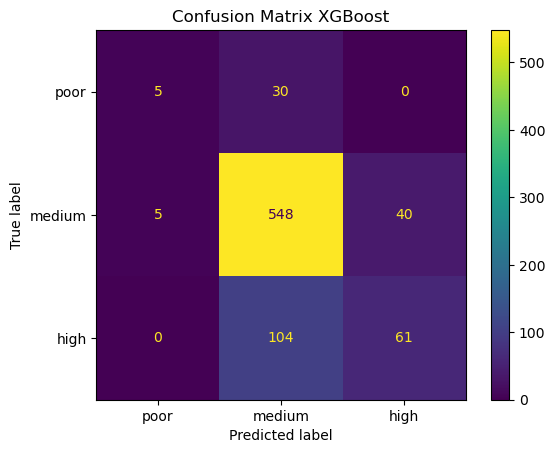

In [166]:
# Plot the confusion matrix
confusion_matrix_displayer(champion_model4, X3_test, y3_test, 'Confusion Matrix XGBoost')

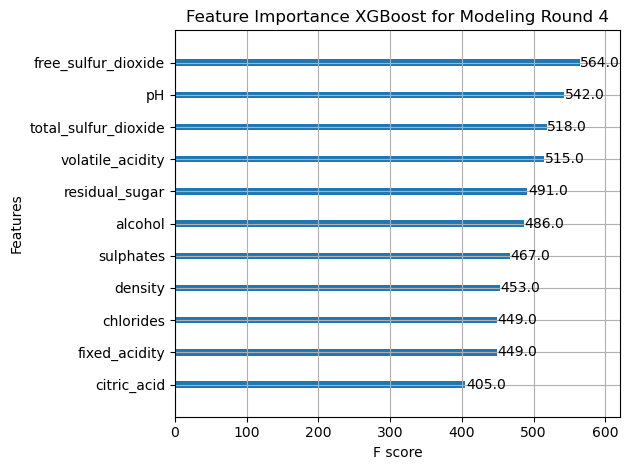

In [167]:
# Plot feature importance to reveal the strong predictors of the target variable
importance_plotter(champion_model4, 'Feature Importance XGBoost for Modeling Round 4')

### Modeling Round 5: Principal Component Analysis

In [198]:
df4 = df.copy()

In [199]:
# Split the data into train and test sets 
X4 = df4.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1)
y4 = df4['quality_cat_code']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, 
                                                    stratify=y4, random_state=22)

# Check the split
for x in [X4_train, X4_test, y4_train, y4_test]: 
    print(len(x))

3168
793
3168
793


#### Determining the number of components to be used in PCA:

In [200]:
scaler = StandardScaler()
scaler.fit(X4)

StandardScaler()

In [201]:
scaled_data = scaler.transform(X4)

In [202]:
from sklearn.decomposition import PCA

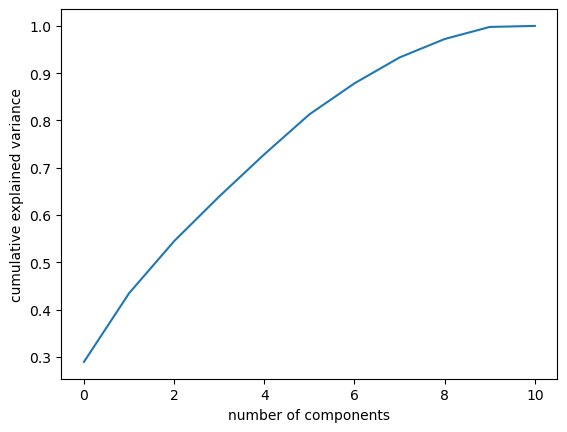

In [203]:
pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [204]:
# Set n_components to 0.95 for 95% explained variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(scaled_data)

print(f'Number of components chosen to explain 95% variance: {pca.n_components_}')

Number of components chosen to explain 95% variance: 9


In [205]:
# Initialize the algorithm
logreg = LogisticRegression(multi_class='multinomial', random_state=42)
knn = KNeighborsClassifier(algorithm='ball_tree')
svm = SVC(random_state=42, probability=True)
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
pca = PCA(n_components=0.95)

In [206]:
# Build pipelines for data preprocessing
pipe_logreg = Pipeline(steps = [('scale', StandardScaler()),
                                ('pca', pca),
                                ('logreg', logreg)])

pipe_knn = Pipeline(steps = [('scale', StandardScaler()),
                             ('pca', pca),
                             ('knn', knn)])

pipe_svm = Pipeline(steps = [('scale', StandardScaler()),
                             ('pca', pca),
                             ('svm', svm)])

pipe_xgb = Pipeline(steps = [('scale', StandardScaler()),
                             ('pca', pca),
                             ('xgb', xgb)])

In [207]:
# Set up the parameter grids for hyperparameter tuning
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4, 4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3, 30,2)),
                   'knn__p': [1, 2]}]
                   
param_grid_svm = [{'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1, 2))}]
                   

param_grid_xgb = [{'xgb__max_depth': [3, 5, 9], 
                   'xgb__min_child_weight': [1, 3, 5],
                   'xgb__subsample': [0.8],
                   'xgb__colsample_bytree': [0.8],
                   'xgb__learning_rate': [0.01, 0.1],
                   'xgb__num_class': [3],
                   'xgb__n_estimators': [100, 300]}]   

In [208]:
# Set Scoring
scoring=['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [209]:
# Set up the multiple GridSearchCV for the inner loop
gridcv = {}
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for pgrid, est, name in zip((param_grid_logreg, param_grid_knn, 
                             param_grid_svm, param_grid_xgb),
                            (pipe_logreg, pipe_knn, pipe_svm, pipe_xgb),
                            ('LogReg', 'KNN', 'SVM', 'XGBoost')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=-1,
                       cv=inner_cv,
                       error_score='raise',
                       refit='f1_weighted')
    gridcv[name] = gcv

In [210]:
# Set up the outer loop for model selection using X3_train, y3_train
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, gs_est in sorted(gridcv.items()):
    scores_dict = cross_validate(gs_est, 
                                X=X4_train,
                                y=y4_train, 
                                scoring=scoring,
                                cv=outer_cv,
                                return_estimator=True,
                                error_score='raise',
                                n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('     Inner loop:')


    for i in range(scores_dict['test_f1_weighted'].shape[0]):    
        print('\n         Best F1: (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('         Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('         F1: (on outer test fold) %.2f%%' % (scores_dict['test_f1_weighted'][i]*100))

    print('\n%s | outer F1: %.2f%% +/- %.2f' %
          (name, scores_dict['test_f1_weighted'].mean() * 100,
           scores_dict['test_f1_weighted'].std() * 100))

    print('\nSUMMARY OF OUTER SCORES:')
    print(pd.DataFrame({'model': [name],
                        'precision': [scores_dict['test_precision_weighted'].mean()],
                        'recall': [scores_dict['test_recall_weighted'].mean()],
                        'F1': [scores_dict['test_f1_weighted'].mean()],
                        'accuracy': [scores_dict['test_balanced_accuracy'].mean()]
                       }))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 74.09%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 72.35%

         Best F1: (avg. of inner test folds) 73.43%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 73.22%

         Best F1: (avg. of inner test folds) 73.63%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=29))])
  

In [212]:
champion_model5 = champion_gcv(pipe_svm, param_grid_svm)

In [213]:
%%time
champion_model5.fit(X4_train, y4_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 1.72 s
Wall time: 39.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid=[{'svm__C': array([ 0.1,  1. , 10. ]),
                          'svm__gamma': ['scale', 'auto'],
                          'svm__kernel': ['linear', 'rbf']}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [214]:
# Save the model
write_pickle(path, champion_model5, 'champion_model_round5')

In [215]:
# Read the pickla
champion_model5 = read_pickle(path, 'champion_model_round5')

In [216]:
champion_model5.best_params_

{'svm__C': 10.0, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

In [179]:
# Assess the performance of the model during validation 
champion_model_results5 = make_results('Champion_5 val', champion_model5, 'f1')
champion_model_results5

,model,precision,recall,f1,accuracy
0,Champion_5 val,0.744533,0.771148,0.745695,0.476393


In [177]:
# Assess the performance of the model using the test set
champion_model_test_scores5 = get_scores('Champion_5 test', champion_model5, X4_test, y4_test)
champion_model_test_scores5

,model,precision,recall,f1,accuracy
0,Champion_5 test,0.774428,0.791929,0.771842,0.540316


In [178]:
results = pd.concat([results, champion_model_results5, champion_model_test_scores5], axis=0)
results

,model,precision,recall,f1,accuracy
0,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,Champion_2 val,0.755184,0.781887,0.758465,0.478868
0,Champion_2 test,0.740301,0.769231,0.745625,0.472054
0,Champion_3 val,0.762146,0.768308,0.764714,0.575687
0,Champion_3 test,0.764850,0.774275,0.768106,0.558692
0,Champion_4 val,0.763124,0.781876,0.756688,0.480364
0,Champion_4 test,0.748601,0.774275,0.748048,0.478890
0,Champion_1 val,0.744533,0.771148,0.745695,0.476393
0,Champion_5 test,0.774428,0.791929,0.771842,0.540316


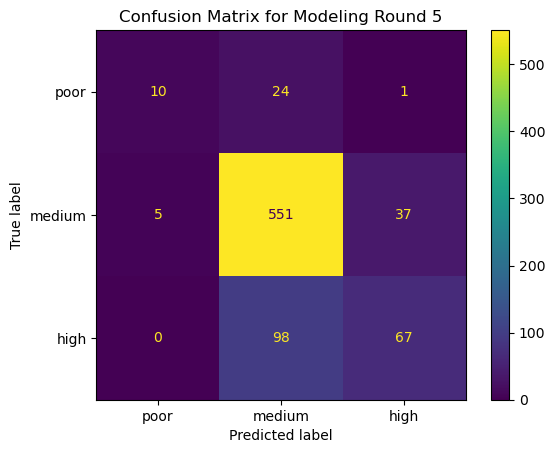

In [188]:
# Plot the confusion matrix
confusion_matrix_displayer(champion_model5, X4_test, y4_test, 'Confusion Matrix for Modeling Round 5')

In [224]:
# Plot the feature importance from pipeline
from sklearn.inspection import permutation_importance
pipeline_svm = champion_model5.best_estimator_
perm_importance = permutation_importance(pipeline_svm, X4_test, y4_test, n_repeats=10, random_state=42)

In [229]:
pipeline_svm.named_steps['pca'].n_components_

9

In [231]:
n_components = min(len(importance), pipeline_svm.named_steps['pca'].n_components_)
n_components

9

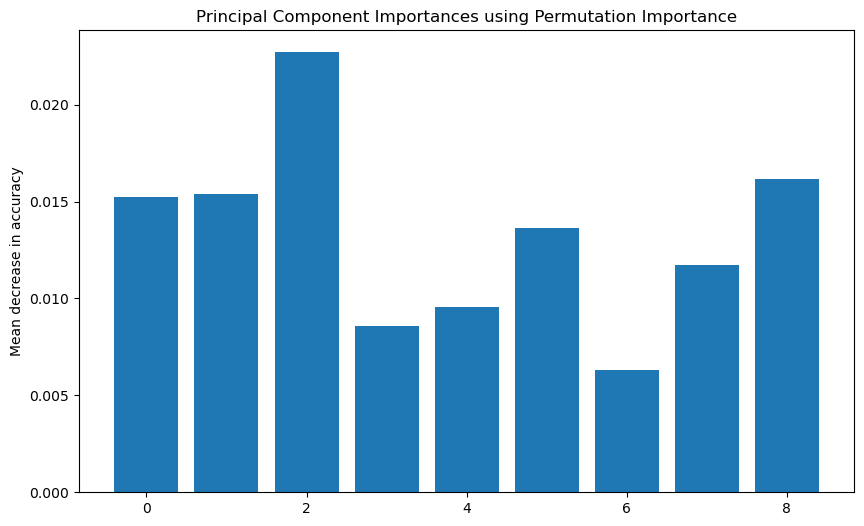

In [232]:
# Get mean importance scores

importance = perm_importance.importances_mean
indices = np.argsort(importance)[::-1]
n_components = min(len(importance), pipeline_svm.named_steps['pca'].n_components_)

# Plot the feature importances
components = [f'PC{i+1}' for i in range(n_components)]
plt.figure(figsize=(10, 6))
plt.title("Principal Component Importances using Permutation Importance")
plt.bar(range(n_components), importance[:n_components], align="center")

plt.ylabel("Mean decrease in accuracy")
plt.show()

* **Understanding Significance:** Components with larger mean decreases in accuracy are more significant for the model. If a component has a mean decrease close to zero or negative, it indicates that shuffling its values doesn't significantly affect the model's accuracy, suggesting it may be less important.

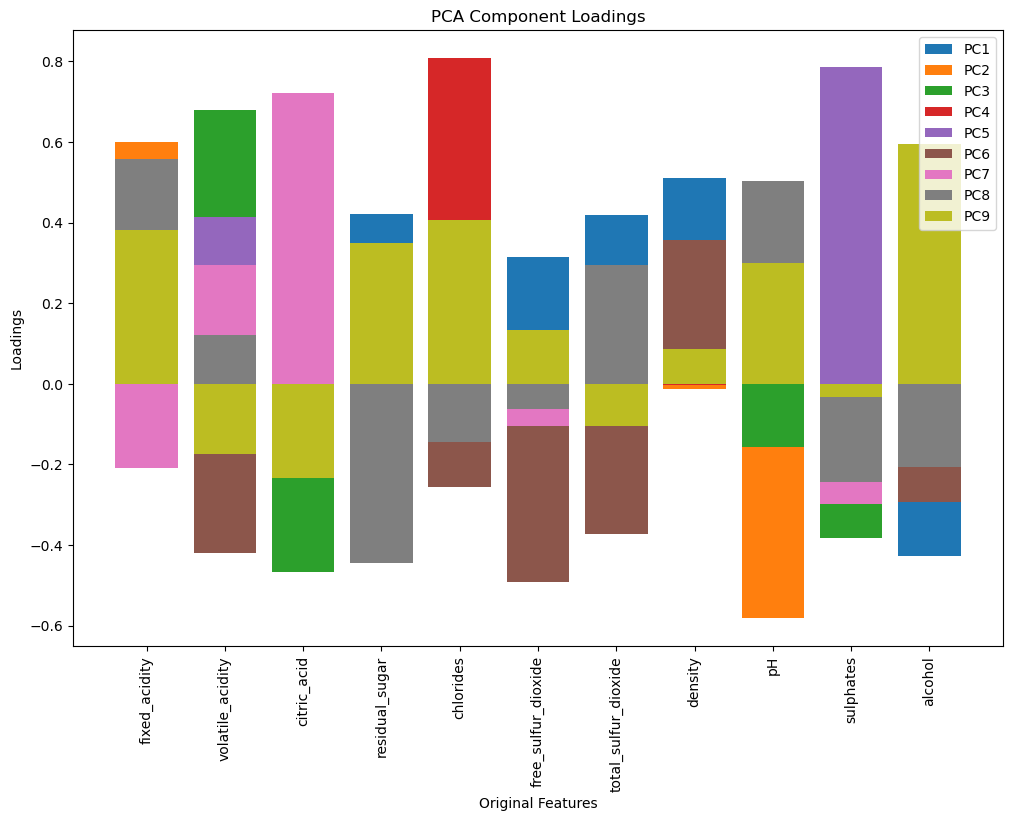

In [222]:
# Extract PCA component loadings
pca = pipeline_svm.named_steps['pca']
loadings = pca.components_.T

# Plot the loadings
plt.figure(figsize=(12, 8))
plt.title("PCA Component Loadings")
for i, component in enumerate(loadings.T):
    plt.bar(range(len(component)), component, label=f'PC{i+1}')
plt.xticks(range(len(X4_train.columns)), X4_train.columns, rotation=90)
plt.xlabel("Original Features")
plt.ylabel("Loadings")
plt.legend(loc='upper right')
plt.show()

In [ ]:
xgb_model = champion_xgb_pipeline.named_steps['xgb']

In [197]:
pipe_svm.named_steps.keys()

dict_keys(['scaler', 'svm'])

# **pacE: Execute Stage**
* Interpret model
* Evaluate model performance using metrics
* Prepare results, visualizations, and actionable steps to share with stakeholders

## Step 4. Results and Evaluation 

Feature Importance: Understanding which features most significantly impact your model’s decisions can provide insights into the dataset

In [63]:
# Plot feature importance

In [64]:
# Plot a confusion matrix

### Summary of model results

## **Conclusion and Recommendations**

## References

[1]: Hopfer, H., & Heymann, H. (2014). Judging wine quality: Do we need experts, 
consumers or trained panelists? Food Quality and Preference, 32, 221-233. 
10.1016/j.foodqual.2013.10.004